# Ink Detection

## Import Modules

In [1]:
import numpy as np
import glob
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import imgaug.augmenters as iaa
import imgaug as ia
import random
#import kornia
import cv2
import time
import datetime
import os
import pandas as pd
import copy
import shutil
from distutils.util import strtobool
import pickle
import platform

In [2]:
import tensorflow as tf
from keras.utils import io_utils, tf_utils
from tensorflow.keras import (layers, models,
                              utils, optimizers,
                              callbacks, regularizers,
                              losses, activations,
                              applications)
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

### Management of GPU memory

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
cpus = tf.config.experimental.list_physical_devices(device_type='CPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Model Classes

#### Layer names of imported backbones

In [4]:
imported_layers = {'EfficientNetB0':['block2a_expand_activation',
                                     'block3a_expand_activation',
                                     'block4a_expand_activation',
                                     'block6a_expand_activation',
                                     'top_activation'],
                  'MobileNetV2':['block_1_expand_relu',
                                 'block_3_expand_relu',
                                 'block_6_expand_relu',
                                 'block_13_expand_relu',
                                 'out_relu']}

### Custom Loss functions and metrics

In [5]:
class Custom_Losses_and_metrics():
    def hybrid_loss(self, y_true, y_pred):
#         y_true_f = np.float32(K.flatten(y_true))
#         y_pred_f = np.float32(K.flatten(y_pred))
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        epsilon = 1e-7
        
        #-----Cross Entropy Part
        Loss_en = K.mean(y_true_f * K.log(y_pred_f + K.epsilon()))
        
        #-----Dice Part
        G = y_true_f * y_pred_f
        Loss_dice = K.mean( G/ \
                          (y_true_f**2 + y_pred_f**2 + K.epsilon()))
        Loss = -(Loss_en + Loss_dice)
        return Loss
    
    def dice_loss(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        epsilon = 1e-7
        
        TP = K.mean(y_true_f * y_pred_f)
        FP = K.mean(y_pred_f) - TP
        FN = K.mean(y_true_f) - TP
        
        Loss = 1 - (2 * TP + epsilon) / (2 * TP + FP + FN + epsilon)
        return Loss
    
    def Sorensen_Dice_loss(self, y_true, y_pred):
        coef = self.Sorensen_Dice_coef(y_true, y_pred)
        loss = 1 - coef
        return loss
    
    def recall(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        tp = K.sum(y_true_f * y_pred_f)
        fn = K.sum(y_true_f) - tp
        r = (tp + K.epsilon()) / (tp + fn + K.epsilon())
        return r
    
    def precision(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum(y_pred_f) - tp
        p = (tp + K.epsilon()) / (tp + fp + K.epsilon())
        return p
    
    def negative_precision(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        tp = K.mean(y_true_f * y_pred_f)
        fp = K.mean(y_pred_f) - tp
        fn = K.mean(y_true_f) - tp
        tn = 1 - tp - fp - fn
        neg_p = (tn + K.epsilon()) / (tn + fn + K.epsilon())
        return neg_p

    def Sorensen_Dice_coef(self, y_true, y_pred):
        beta = 0.5
        p = self.precision(y_true, y_pred)
        r = self.recall(y_true, y_pred)

        coef = ((1 + beta**2) * p * r + K.epsilon()**2) / ((beta**2) * p + r + K.epsilon()**2)

        return coef

CLM = Custom_Losses_and_metrics()
hybrid_loss = CLM.hybrid_loss
dice_loss = CLM.dice_loss
recall = CLM.recall
precision = CLM.precision
negative_precision = CLM.negative_precision
Sorensen_Dice_coef = CLM.Sorensen_Dice_coef
Sorensen_Dice_loss = CLM.Sorensen_Dice_loss

### UNET family

#### UNET

In [6]:
class UNET():
    def __init__(self,
                 threeD_conv=False,
                 threeD_conv_range='initial',
                 block_num=5,
                 sub_layers=3,
                 res=False,
                 up_sample='up_sample',
                 multi_Resolution=False,
                 resolution_strides=[2, 3, 4],
                 conv_dropout=0,
                 conv_dropout_0=0,
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16, 32, 64, 128, 256, 512],
                 num_classes=1,
                 y_process='none',
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 depth_Fourier=False):
        self.encoder_list = ['EfficientNetB0',]
        self.threeD_conv = threeD_conv
        self.threeD_conv_range = threeD_conv_range
        self.block_num = block_num
        self.sub_layers = sub_layers
        self.res = res
        self.up_sample = up_sample
        self.multi_Resolution = multi_Resolution
        self.resolution_strides = resolution_strides
        self.conv_dropout = conv_dropout
        self.conv_dropout_0 = conv_dropout_0
        self.dropout_factor = dropout_factor
        self.L2_factor = L2_factor
        self.filter_list = filter_list[0:block_num]
        self.y_process = y_process
        self.encoder = encoder
        self.transfer_trainable = transfer_trainable
        self.regularizer = regularizers.l2(self.L2_factor)
        self.bias_regularizer = regularizers.l2(self.L2_factor)
        self.depth_Fourier = depth_Fourier

        if not self.encoder in self.encoder_list:
            self.transfer = False
        else:
            self.transfer = transfer

        if num_classes <= 2:
            self.num_classes = 1
        else:
            self.num_classes = num_classes

    def AverageAndReshapeLayer(self, input_layer, axis=3):
        input_layer = tf.reduce_mean(input_layer, axis=axis)
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        shape = (-1,)
        for i in range(1, input_dim):
            shape += (input_shape[i],)
        l = tf.reshape(input_layer, shape=shape)
        return l
    
    def MaxAndReshapeLayer(self, input_layer, axis=3):
        input_layer = tf.reduce_max(input_layer, axis=axis)
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        shape = (-1,)
        for i in range(1, input_dim):
            shape += (input_shape[i],)
        l = tf.reshape(input_layer, shape=shape)
        return l
    
    def ReduceDimLayer(self, input_layer, axis=3):
        l = self.MaxAndReshapeLayer(input_layer, axis)
        return l
    
    def ExpandDimension(self, input_layer, axis=3):
        shape = (-1,)
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        for i in range(1, input_dim):
            if not i == axis:
                shape += (input_shape[i],)
            else:
                shape += (1,)
                shape += (input_shape[i],)
        l = tf.reshape(input_layer, shape=shape)
        return l

    def Conv2D_Cell(self, input_layer, filters, dropout=True):
        l = layers.Conv2D(filters=filters,
                          kernel_size=[3, 3],
                          kernel_regularizer=self.regularizer,
                          bias_regularizer=self.bias_regularizer,
                          padding='same')(input_layer)
        l = layers.BatchNormalization()(l)
        l = layers.Activation(activations.relu)(l)
        if dropout:
            l = layers.Dropout(self.conv_dropout)(l)
        return l

    def Conv3D_Cell(self, input_layer, filters, dropout=True):
        l = layers.Conv3D(filters=filters,
                          kernel_size=[3, 3, 3],
                          kernel_regularizer=self.regularizer,
                          bias_regularizer=self.bias_regularizer,
                          padding='same')(input_layer)
        l = layers.BatchNormalization()(l)
        l = layers.Activation(activations.relu)(l)
        if dropout:
            l = layers.Dropout(self.conv_dropout)(l)
        return l

    def Conv_Cell_Encoder(self, input_layer, filters, dropout=True):
        if self.threeD_conv and self.threeD_conv_range in ['all', 'encoder']:
            l = self.Conv3D_Cell(input_layer, filters, dropout)
        else:
            l = self.Conv2D_Cell(input_layer, filters, dropout)
        return l

    def Conv_Cell_Decoder(self, input_layer, filters, dropout=True):
        if self.threeD_conv and self.threeD_conv_range in ['all', 'decoder']:
            l = self.Conv3D_Cell(input_layer, filters, dropout)
        else:
            l = self.Conv2D_Cell(input_layer, filters, dropout)
        return l

    def Res_Block_Encoder(self, input_layer, filters, dropout=True):
        l = self.Conv_Cell_Encoder(input_layer, filters, dropout)
        l = self.Conv_Cell_Encoder(l, input_layer.shape[-1], dropout)
        l = layers.Add()([input_layer, l])
        l = self.Conv_Cell_Encoder(l, filters, dropout=True)
        return l

    def Res_Block_Decoder(self, input_layer, filters, dropout=True):
        l = self.Conv_Cell_Decoder(input_layer, filters, dropout)
        l = self.Conv_Cell_Decoder(l, input_layer.shape[-1], dropout)
        l = layers.Add()([input_layer, l])
        l = self.Conv_Cell_Decoder(l, filters, dropout=True)
        return l

    def DownWard_Block(self, input_layer, this_filters, sub_layers):
        if self.res:
            this_C_Cell = self.Res_Block_Encoder
        else:
            this_C_Cell = self.Conv_Cell_Encoder
        for i in range(sub_layers):
            if i == 0:
                if self.conv_dropout > 0:
                    l = this_C_Cell(
                        input_layer, filters=this_filters, dropout=True)
                else:
                    l = this_C_Cell(input_layer, filters=this_filters)
            elif i == sub_layers-2 and self.conv_dropout > 0:
                l = this_C_Cell(l, filters=this_filters, dropout=True)
            else:
                l = this_C_Cell(l, filters=this_filters)
        if self.threeD_conv and self.threeD_conv_range in ['all', 'encoder']:
            l = layers.MaxPool3D(pool_size=(2, 2, 1))(l)
        else:
            l = layers.MaxPool2D()(l)
        return (l)

    def UpWard_Block(self, input_layer, this_filters, sub_layers):
        if self.res:
            this_C_Cell = self.Res_Block_Decoder
        else:
            this_C_Cell = self.Conv_Cell_Decoder
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        if self.threeD_conv and self.threeD_conv_range in ['all', 'decoder']:
            
            if input_dim == 4:
                input_layer = self.ExpandDimension(input_layer)
        else:
            if input_dim == 5:
                input_layer = self.ReduceDimLayer(input_layer)

        for i in range(sub_layers):
            if i == 0:
                l = this_C_Cell(input_layer, filters=this_filters)
            elif i == sub_layers-2 and self.conv_dropout > 0:
                l = this_C_Cell(l, filters=this_filters, dropout=True)
            else:
                l = this_C_Cell(l, filters=this_filters)
        
        if self.threeD_conv and self.threeD_conv_range in ['all', 'decoder']:
            if self.up_sample == 'up_sample':
                l = layers.UpSampling3D(size=(2, 2, 1))(l)
            elif self.up_sample == 'conv2dtranspose':
                l = layers.Conv3DTranspose(filters=this_filters,
                                           kernel_size=[3, 3, 3],
                                           strides=(2, 2, 1),
                                           padding='same')(l)
                l = layers.BatchNormalization()(l)
                l = layers.Activation(activations.relu)(l)
        else:
            if self.up_sample == 'up_sample':
                l = layers.UpSampling2D(size=(2, 2))(l)
            elif self.up_sample == 'conv2dtranspose':
                l = layers.Conv2DTranspose(filters=this_filters,
                                           kernel_size=[3, 3],
                                           strides=(2, 2),
                                           padding='same')(l)
                l = layers.BatchNormalization()(l)
                l = layers.Activation(activations.relu)(l)
        return (l)

    def input_stem(self, input_layer):
        #print(self.threeD_conv)
        if self.threeD_conv:
            l = layers.Conv3D(kernel_size=[1, 1, 3], filters=32,
                              kernel_regularizer=self.regularizer,
                              bias_regularizer=self.bias_regularizer)(input_layer)
            l = layers.BatchNormalization()(l)
            l = layers.Activation(activations.relu)(l)
            l = layers.Dropout(self.dropout_factor)(l)
            l = layers.Conv3D(kernel_size=[1, 1, 7], filters=self.filter_list[0],
                              kernel_regularizer=self.regularizer,
                              bias_regularizer=self.bias_regularizer)(l)
            l = layers.BatchNormalization()(l)
            l = layers.Activation(activations.relu)(l)
            l = layers.Dropout(self.dropout_factor)(l)
#             l = layers.Conv3D(kernel_size=[1, 1, 11], filters=self.filter_list[0],
#                               kernel_regularizer=self.regularizer,
#                               bias_regularizer=self.bias_regularizer,
#                               padding='same')(l)
#             l = layers.BatchNormalization()(l)
#             l = layers.Activation(activations.relu)(l)
#             l = layers.Dropout(self.dropout_factor)(l)
            l = layers.Conv3D(kernel_size=[3, 3, 3], filters=self.filter_list[0],
                              kernel_regularizer=self.regularizer,
                              bias_regularizer=self.bias_regularizer,
                              padding='same')(l)
            l = layers.BatchNormalization()(l)
            l = layers.Activation(activations.relu)(l)
            if self.threeD_conv_range == 'initial':
                l = self.ReduceDimLayer(l)
            #print(tf.shape(l))
        else:
            if self.depth_Fourier:
                l = layers.BatchNormalization()(input_layer)
                l = layers.Conv2D(kernel_size=[1, 1], filters=32,
                                  kernel_regularizer=self.regularizer,
                                  bias_regularizer=self.bias_regularizer)(l)
            else:
                l = layers.Conv2D(kernel_size=[1, 1], filters=32,
                                  kernel_regularizer=self.regularizer,
                                  bias_regularizer=self.bias_regularizer)(input_layer)
            l = layers.BatchNormalization()(l)
            l = layers.Activation(activations.relu)(l)
            l = layers.Dropout(self.dropout_factor)(l)
            l = layers.Conv2D(kernel_size=[1, 1], filters=self.filter_list[0],
                              kernel_regularizer=self.regularizer,
                              bias_regularizer=self.bias_regularizer)(l)
            l = layers.BatchNormalization()(l)
            l = layers.Activation(activations.relu)(l)
        return l

    def Pretrained_Encoder(self, input_layer):
        if self.encoder == 'EfficientNetB0':
            this_Encoder = applications.EfficientNetB0

        l = self.input_stem(input_layer)
        outputs = [l]
        Back_Bone = this_Encoder(
            include_top=False, weights=None, input_tensor=l)

        C_layers_name = imported_layers[self.encoder]
        Cs = [Back_Bone.get_layer(name).output for name in C_layers_name]
        for i in range(self.block_num):
            outputs.append(Cs[i])
        # outputs = Cs[0:self.block_num]
        return outputs

    def Vanilla_Encoder(self, input_layer):
        l = self.input_stem(input_layer)
        #print(tf.shape(l))
        outputs = [l]
        for i in range(self.block_num):
            if i == 0:
                l = self.DownWard_Block(l,
                                        this_filters=self.filter_list[i],
                                        sub_layers=self.sub_layers)
            else:
                l = self.DownWard_Block(l,
                                        this_filters=self.filter_list[i],
                                        sub_layers=self.sub_layers)
            outputs.append(l)
        return outputs

    def DownWard_Stream(self, input_layer):
        if self.encoder == 'vanilla':
            outputs = self.Vanilla_Encoder(input_layer)
        elif self.encoder in self.encoder_list:
            outputs = self.Pretrained_Encoder(input_layer)
        return outputs

    def UpWard_Stream(self, input_layers):
        for i in range(self.block_num):
            if i == 0:
                l = self.UpWard_Block(input_layers[-1],
                                      this_filters=self.filter_list[-i-1],
                                      sub_layers=self.sub_layers)
            else:
                l = self.UpWard_Block(l,
                                      this_filters=self.filter_list[-i-1],
                                      sub_layers=self.sub_layers)
            l = self.Concatenate(i, input_layers, l)
        return l

    def Concatenate(self, i, input_layers, l):
        j = input_layers[-i-2]
        l_shape = l.get_shape(); l_dim = len(l_shape)
        j_shape = j.get_shape(); j_dim = len(j_shape)
        if l_dim > j_dim:
            j = self.ExpandDimension(j)
        elif l_dim < j_dim:
            j = self.ReduceDimLayer(j)
        l = layers.concatenate([l, j])
        l = layers.BatchNormalization()(l)
        return l

    def Segmentation_Stem(self, input_layer, activation=True):
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        if input_dim == 5:
            input_layer = self.ReduceDimLayer(input_layer)
        l = layers.Dropout(self.dropout_factor)(input_layer)
        l = layers.Conv2D(filters=self.num_classes,
                          kernel_size=[1, 1],
                          #activation='sigmoid',
                          padding='same',
                          kernel_regularizer=self.regularizer,
                          bias_regularizer=self.bias_regularizer)(l)
        if activation:
            l = layers.Activation(activations.sigmoid)(l)
        return l

    def SingleValue_Stem(self, input_layer, activation=True):
        input_shape = input_layer.get_shape()
        input_dim = len(input_shape)
        if input_dim == 5:
            input_layer = self.ReduceDimLayer(input_layer)
        l = layers.GlobalAveragePooling2D(input_layer)
        l = layers.Dropout(self.dropout_factor)(l)
        l = layers.Dense(self.num_classes,
                         #activation='sigmoid',
                         kernel_regularizer=self.regularizer,
                         bias_regularizer=self.bias_regularizer)(input_layer)
        if activation:
            l = layers.Activation(activations.sigmoid)(l)
        return l

    def Add_regularizer_into_pretrained_backbone(self, model):
        for layer in model.layers:
            if len(layer.trainable_weights) > 0:
                try:
                    if layer.kernel_regularizer == None:
                        layer.add_loss(lambda: (tf.math.reduce_variance(layer.kernel) +
                                                tf.math.reduce_mean(layer.kernel)**2) * self.L2_factor)
                        layer.add_loss(lambda: (tf.math.reduce_variance(layer.bias) +
                                                tf.math.reduce_mean(layer.bias)**2) * self.L2_factor)
                        print(layer.name)
                except:
                    pass
        return model

    def Get_PreTrained_Weights(self, model):
        if self.encoder == 'EfficientNetB0':
            C_layer_names = imported_layers['EfficientNetB0']
            Encoder_for_weight = applications.EfficientNetB0(
                include_top=False, weights='imagenet')
#             for i in range(30):
#                 print(f'Index = {i}')
#                 print(model.layers[i+1].name)
#                 print(len(model.layers[i+1].get_weights()))
#                 print(Encoder_for_weight.layers[i].name)
#                 print(len(Encoder_for_weight.layers[i].get_weights()))
            # for i in range(5, len(Encoder_for_weight.layers)):
            run = True
            i = 8
            while run:
                #                 print(model.layers[i].name)
                #                 print(Encoder_for_weight.layers[i-3].name)
                model.layers[i].set_weights(
                    Encoder_for_weight.layers[i-3].get_weights())
                if not self.transfer_trainable:
                    model.layers[i].trainable = False
                else:
                    model.layers[i].trainable = True
#                     if len(model.layers[i].trainable_weights) > 0:
#                         model.layers[i].add_regularizer(self.regularizer)
                if model.layers[i].name == C_layer_names[self.block_num - 1]:
                    run = False
                else:
                    i += 1

        return model

    def Output(self, input_layer, activation=True):
        res_layers = self.DownWard_Stream(input_layer)
        l = self.UpWard_Stream(res_layers)
        if not self.y_process == 'single_value':
            output_layer = self.Segmentation_Stem(l, activation=activation)
        else:
            output_layer = self.SingleValue_Stem(l, activation=activation)
        return output_layer

    def Multi_Resolution_Output(self, input_layer):
        
        input_dim = len(input_layer.shape)
        multi_output_layers = []
        for stride in self.resolution_strides:
            if input_dim == 5:
                l = layers.AveragePooling3D((stride, stride, 1))(input_layer)
            else:
                l = layers.AveragePooling2D((stride, stride))(input_layer)
                
            this_output_layers = self.Output(l, activation=False)
            
            for i in range(len(this_output_layers)):
                this_output_layers[i] = layers.UpSampling2D((stride, stride))(this_output_layers[i])
                
            multi_output_layers.append(this_output_layers)
            
            
        ture_output_layers = []
        for i in range(len(multi_output_layers[0])):
            this_true_op = multi_output_layers[0][i]
            for j in range(1, len(self.resolution_strides)):
                this_true_op = layers.concatenate([this_true_op, multi_output_layers[j][i]])
            
            this_true_op = layers.ZeroPadding2D(3)(this_true_op)
            this_true_op = layers.Conv2D(16, [7, 7],
                          kernel_regularizer=self.regularizer,
                          bias_regularizer=self.bias_regularizer)(this_true_op)
            this_true_op = layers.BatchNormalization()(this_true_op)
            this_true_op = layers.Activation(activations.relu)(this_true_op)
            this_true_op = layers.Dropout(self.dropout_factor)(this_true_op)
            this_true_op = layers.Conv2D(1, [1, 1],
                          kernel_regularizer=self.regularizer,
                          bias_regularizer=self.bias_regularizer)(this_true_op)
            this_true_op = layers.Activation(activations.sigmoid)(this_true_op)
        ture_output_layers.append(this_true_op)
        return ture_output_layers
    
    def Build_Model(self, input_shape):
        input_layer = layers.Input(input_shape)
        if self.multi_Resolution:
            output_layer = self.Multi_Resolution_Output(input_layer)
        else:
            output_layer = self.Output(input_layer)
        model = models.Model(input_layer, output_layer)

        if self.transfer:
            model = self.Get_PreTrained_Weights(model)

        if self.transfer_trainable:
            model = self.Add_regularizer_into_pretrained_backbone(model)

        return model

#### UNET A

In [7]:
class UNET_A(UNET):
    def __init__(self,
                 threeD_conv=False,
                 threeD_conv_range='initial',
                 block_num=5,
                 sub_layers=3,
                 res=False,
                 up_sample='up_sample',
                 multi_Resolution=False,
                 resolution_strides=[2, 3, 4],
                 conv_dropout=0,
                 conv_dropout_0=0,
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16,32,64,128,256,512],
                 num_classes=1,
                 y_process='none',
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 depth_Fourier=False):
        super().__init__(threeD_conv=threeD_conv,
                         threeD_conv_range=threeD_conv_range,
                         block_num=block_num,
                         sub_layers=sub_layers,
                         res=res,
                         up_sample=up_sample,
                         resolution_strides=resolution_strides,
                         multi_Resolution=multi_Resolution,
                         conv_dropout=conv_dropout,
                         conv_dropout_0=conv_dropout_0,
                         dropout_factor=dropout_factor,
                         L2_factor=L2_factor,
                         filter_list=filter_list,
                         num_classes=num_classes,
                         y_process=y_process,
                         encoder=encoder,
                         transfer=transfer,
                         transfer_trainable=transfer_trainable,
                         depth_Fourier=depth_Fourier)
    
    def Concatenate(self, i, input_layers, l):
        for k in range(-i-2,-len(input_layers)-1,-1):
            j = input_layers[k]
            l_shape = l.get_shape(); l_dim = len(l_shape)
            j_shape = j.get_shape(); j_dim = len(j_shape)
            if l_dim > j_dim:
                j = self.ExpandDimension(j)
            elif l_dim < j_dim:
                j = self.AverageAndReshapeLayer(j)
            MP_ratio = int(j.shape[1] / l.shape[1])
            j = layers.MaxPool2D((MP_ratio, MP_ratio))(j)
            l = layers.concatenate([l, j])
        l = layers.BatchNormalization()(l)
        return l

#### UNET +

In [8]:
class UNET_plus(UNET):
    def __init__(self,
                 threeD_conv=False,
                 threeD_conv_range='initial',
                 block_num=5,
                 sub_layers=3,
                 res=False,
                 up_sample='up_sample',
                 multi_Resolution=False,
                 resolution_strides=[2, 3, 4],
                 conv_dropout=0,
                 conv_dropout_0=0,
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16,32,64,128,256,512],
                 num_classes=1,
                 y_process='none',
                 supervision=False,
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 depth_Fourier=False):
        super().__init__(threeD_conv=threeD_conv,
                         threeD_conv_range=threeD_conv_range,
                         block_num=block_num,
                         sub_layers=sub_layers,
                         res=res,
                         up_sample=up_sample,
                         resolution_strides=resolution_strides,
                         multi_Resolution=multi_Resolution,
                         conv_dropout=conv_dropout,
                         conv_dropout_0=conv_dropout_0,
                         dropout_factor=dropout_factor,
                         L2_factor=L2_factor,
                         filter_list=filter_list,
                         num_classes=num_classes,
                         y_process=y_process,
                         encoder=encoder,
                         transfer=transfer,
                         transfer_trainable=transfer_trainable,
                         depth_Fourier=depth_Fourier)
        self.supervision = supervision
        self.layers = {}
    
    def DownWard_Stream(self, input_layer):
        if self.encoder == 'vanilla':
            outputs = self.Vanilla_Encoder(input_layer)
        elif self.encoder in ['EfficientNetB0',]:
            outputs = self.Pretrained_Encoder(input_layer)
        for i, l in enumerate(outputs):
            self.layers[f'{i+1}_0'] = l
            
    def Concatenate(self, l, j):
        l_shape = l.get_shape(); l_dim = len(l_shape)
        j_shape = j.get_shape(); j_dim = len(j_shape)
        if l_dim > j_dim:
            j = self.ExpandDimension(j)
        elif l_dim < j_dim:
            j = self.AverageAndReshapeLayer(j)
        l = layers.concatenate([l, j])
        l = layers.BatchNormalization()(l)
        return l
    
    def UpWard_Stream(self, block_num):
        for i in range(block_num):
            this_num_filter = self.filter_list[block_num - i - 1]
            if i == 0:
                l = self.UpWard_Block(self.layers[f'{block_num}_0'],
                                      this_filters=this_num_filter,
                                      sub_layers=self.sub_layers)
            else:
                l = self.UpWard_Block(l,
                                      this_filters=this_num_filter,
                                      sub_layers=self.sub_layers)
            j = self.layers[f'{block_num - i - 1}_{i}']    
            l = self.Concatenate(l, j)
            self.layers[f'{block_num - i - 1}_{i+1}'] = l
            
    def Output(self, input_layer, activation=True):
        self.layers['0_0'] = input_layer
        self.DownWard_Stream(input_layer)
        for j in range(self.block_num):
            self.UpWard_Stream(block_num=j+1)
        
        if self.supervision:
            medium_layers = [self.layers[f'{0}_{i}'] for i in range(1, self.block_num+1)]
        else:
            medium_layers = [self.layers[f'{0}_{self.block_num}']]
        
        output_layers = []
        for l in medium_layers:
            if not self.y_process == 'single_value':
                output_layers.append(self.Segmentation_Stem(l, activation=activation))
            else:
                output_layers.append(self.SingleValue_Stem(l, activation=activation))
        return output_layers

#### UNET++

In [9]:
class UNET_2plus(UNET_plus):
    def __init__(self,
                 threeD_conv=False,
                 threeD_conv_range='initial',
                 block_num=5,
                 sub_layers=3,
                 res=False,
                 up_sample='up_sample',
                 multi_Resolution=False,
                 resolution_strides=[2, 3, 4],
                 conv_dropout=0,
                 conv_dropout_0=0,
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16,32,64,128,256,512],
                 num_classes=1,
                 y_process='none',
                 supervision=False,
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 depth_Fourier=False):
        super().__init__(threeD_conv=threeD_conv,
                         threeD_conv_range=threeD_conv_range,
                         block_num=block_num,
                         sub_layers=sub_layers,
                         res=res,
                         up_sample=up_sample,
                         resolution_strides=resolution_strides,
                         multi_Resolution=multi_Resolution,
                         conv_dropout=conv_dropout,
                         conv_dropout_0=conv_dropout_0,
                         dropout_factor=dropout_factor,
                         L2_factor=L2_factor,
                         filter_list=filter_list,
                         num_classes=num_classes,
                         y_process=y_process,
                         encoder=encoder,
                         transfer=transfer,
                         transfer_trainable=transfer_trainable,
                         supervision=supervision,
                         depth_Fourier=depth_Fourier)
    
    def UpWard_Stream(self, block_num):
        for i in range(block_num):
            this_num_filter = self.filter_list[block_num - i - 1]
            if i == 0:
                l = self.UpWard_Block(self.layers[f'{block_num}_0'],
                                      this_filters=this_num_filter,
                                      sub_layers=self.sub_layers)
            else:
                l = self.UpWard_Block(l,
                                      this_filters=this_num_filter,
                                      sub_layers=self.sub_layers)
            for key in self.layers.keys():
                if int(key.split('_')[0]) == (block_num - i - 1):
                    j = self.layers[key]   
                    l = self.Concatenate(l, j)
            self.layers[f'{block_num - i - 1}_{i+1}'] = l

#### UNET+++

In [10]:
class UNET_3plus(UNET_A):
    def __init__(self,
                 threeD_conv=False,
                 threeD_conv_range='initial',
                 block_num=5,
                 sub_layers=3,
                 res=False,
                 up_sample='up_sample',
                 multi_Resolution=False,
                 resolution_strides=[2, 3, 4],
                 conv_dropout=0,
                 conv_dropout_0=0,
                 dropout_factor=0,
                 L2_factor=1e-15,
                 filter_list=[16,32,64,128,256,512],
                 num_classes=1,
                 y_process='none',
                 supervision=False,
                 encoder='vanilla',
                 transfer=False,
                 transfer_trainable=False,
                 depth_Fourier=False):
        super().__init__(threeD_conv=threeD_conv,
                         threeD_conv_range=threeD_conv_range,
                         block_num=block_num,
                         sub_layers=sub_layers,
                         res=res,
                         up_sample=up_sample,
                         multi_Resolution=multi_Resolution,
                         resolution_strides=resolution_strides,
                         conv_dropout=conv_dropout,
                         conv_dropout_0=conv_dropout_0,
                         dropout_factor=dropout_factor,
                         L2_factor=L2_factor,
                         filter_list=filter_list,
                         num_classes=num_classes,
                         y_process=y_process,
                         encoder=encoder,
                         transfer=transfer,
                         transfer_trainable=transfer_trainable,
                         depth_Fourier=depth_Fourier)
        self.supervision = supervision
        
    def UpWard_Stream(self, input_layers):
        outputs = []
#         for l in input_layers:
# #             print(l.get_shape())
        for i in range(self.block_num):
            if i == 0:
                l = self.UpWard_Block(input_layers[-1],
                                      this_filters=self.filter_list[-i-1],
                                      sub_layers=self.sub_layers)
            else:
                l = self.UpWard_Block(l,
                                      this_filters=self.filter_list[-i-1],
                                      sub_layers=self.sub_layers)
            l = self.Concatenate(i, input_layers, l)
            input_layers.append(l)
            if self.supervision:
                outputs.append(l)
        if not self.supervision:
            outputs = [l,]
        return outputs
    
    def Concatenate(self, i, input_layers, l):
        concate_idx = [*range(self.block_num-i)] + [*range(self.block_num, self.block_num+i)]
#         print(i, concate_idx)
        for k in concate_idx:
            j = input_layers[k]
            l_shape = l.get_shape(); l_dim = len(l_shape)
            j_shape = j.get_shape(); j_dim = len(j_shape)
#             print(l_shape)
#             print(j_shape)
            if l_dim > j_dim:
                j = self.ExpandDimension(j)
            elif l_dim < j_dim:
                j = self.AverageAndReshapeLayer(j)
            MP_ratio = int(j_shape[1] / l_shape[1])
            #print(k, j.shape[1], l.shape[1], MP_ratio)
            if MP_ratio > 1:
                j = layers.MaxPool2D((MP_ratio, MP_ratio))(j)
            elif MP_ratio < 1:
                UP_ratio = int(l_shape[1] / j_shape[1])
                if l_dim == 5:
                    if self.up_sample == 'up_sample':
                        j = layers.UpSampling3D(size=(UP_ratio, UP_ratio, 1))(j)
                    elif self.up_sample == 'conv2dtranspose':
                        j = layers.Conv3DTranspose(filters=this_filters,
                                                   kernel_size=[3, 3, 3],
                                                   strides=(UP_ratio, UP_ratio, 1),
                                                   padding='same')(j)
                        j = layers.BatchNormalization()(j)
                        j = layers.Activation(activations.relu)(j)
                elif l_dim == 4:
                    if self.up_sample == 'up_sample':
                        j = layers.UpSampling2D(size=(UP_ratio, UP_ratio))(j)
                    elif self.up_sample == 'conv2dtranspose':
                        j = layers.Conv2DTranspose(filters=this_filters,
                                                   kernel_size=[3, 3, 3],
                                                   strides=(UP_ratio, UP_ratio),
                                                   padding='same')(j)
                        j = layers.BatchNormalization()(j)
                        j = layers.Activation(activations.relu)(j)
            l = layers.concatenate([l, j])
        l = layers.BatchNormalization()(l)
        return l
    
    def Output(self, input_layer, activation=True):
        res_layers = self.DownWard_Stream(input_layer)
        outputs = self.UpWard_Stream(res_layers)
        output_height = input_layer.get_shape()[1]
        output_layers = []
        for l in outputs:
            this_height = l.get_shape()[1]
            this_dim = len(l.get_shape())
            if this_height < output_height:
                Up_ratio = output_height/this_height
                if this_dim == 5:
                    l = layers.UpSampling3D((Up_ratio, Up_ratio, 1))(l)
                elif this_dim == 4:
                    l = layers.UpSampling2D((Up_ratio, Up_ratio))(l)
            if not self.y_process == 'single_value':
                output_layer = self.Segmentation_Stem(l, activation=activation)
            else:
                output_layer = self.SingleValue_Stem(l, activation=activation)
            output_layers.append(output_layer)
        return output_layers
    
#     def Build_Model(self, input_shape):
#         input_layer = layers.Input(input_shape)
#         output_layers = self.Output(input_layer)
# #         print(output_layers)
#         model = models.Model(input_layer, output_layers)

#         if self.transfer:
#             model = self.Get_PreTrained_Weights(model)

#         if self.transfer_trainable:
#             model = self.Add_regularizer_into_pretrained_backbone(model)

#         return model
    
#     def Mulit_Resolution_Build_Model(self, input_shape):
#         input_layer = layers.Input(input_shape)
        
#         model = models.Model(input_layer, ture_output_layers)

#         if self.transfer:
#             model = self.Get_PreTrained_Weights(model)

#         if self.transfer_trainable:
#             model = self.Add_regularizer_into_pretrained_backbone(model)

#         return model

## Inintial Parameter preparation

### Fix Parameters

In [11]:
xray_patches = [0, 1, 2]
num_classes = 1

### Directory Making Method

In [12]:
def make_directories(this_model_path=None):
    if not this_model_path:
        date_str = datetime.date.today().strftime('20'+'%y-%m-%d')

        path_string = date_str + '_' + model_mode
        if not y_process == 'none':
            path_string += '_'
            path_string += y_process

        ListD = os.listdir()
        existing_path = []
        for L in ListD:
            if path_string in L:
                existing_path.append(L)

        existing_path_idxs = np.sort([int(p.split('_')[-1]) for p in existing_path])
        if len(existing_path_idxs) >= 1:
            this_index = existing_path_idxs[-1]+1
        else:
            this_index = 0

        this_model_path = './' + path_string + '_' + str(this_index) + '/'
            
    if not os.path.exists(this_model_path):
        os.mkdir(this_model_path)
    
    this_model_weight_path = this_model_path + 'weights/'
    this_model_history_path = this_model_path + 'history/'

    if not os.path.exists(this_model_weight_path):
        os.mkdir(this_model_weight_path)
    if not os.path.exists(this_model_history_path):
        os.mkdir(this_model_history_path)
    
    return this_model_path, this_model_weight_path, this_model_history_path

### Defining or Loading Parameters

In [13]:
running_mode = 'evaluate'  # 'continue_train', 'evaluate', 'new', 'optuna'
early_stop = True
if not running_mode in ['new', 'optuna']:
    new_dir = False
    old_path = './2024-04-04_UNET_3plus_8/'
else:
    new_dir = True
epochs = 800

In [14]:
if new_dir:
    #-----Depth Slices
    slices = [*range(16, 40)]
    #-----Binning
    binning_method = 'Multi-Resolution' # 'DataLoader', 'Multi-Resolution'
    if binning_method == 'DataLoader':
        expand_sample_2d = [3, 3]
        patch_size = 64
        multi_Resolution = False
        resolution_strides = None
    elif binning_method == 'Multi-Resolution':
        expand_sample_2d = [2, 2]
        patch_size = 96
        multi_Resolution = True
        resolution_strides = [2, 3, 4]
    
    #-----Method to get training data for each epoch.
    #-----The method will decide the dropout and L2.
    
    random_training_set = True
    loss_flag = 'Sorensen_Dice_loss'  # 'binary_crossentropy', 'hybrid_loss', 'dice_loss', 'Sorensen_Dice_loss'
    epochs = 800
    if random_training_set:
        batch_size = 32  # Smaller than 2**21 / patch_size**2
        train_size = 2048  # Better to be smaller than 2**23 / patch_size**2
        train_per_epoch_propotion = 0.1
        dropout_factor = 0.35
        conv_dropout = 0.35
        conv_dropout_0 = 0.35
        L2_factor = 10**(-3.30)
    else:
        batch_size = 32  # Smaller than 2**21 / patch_size**2
        train_size = 2048  # Better to be smaller than 2**23 / patch_size**2
        train_per_epoch_propotion = 1
        dropout_factor = 0.7
        conv_dropout = 0.7
        conv_dropout_0 = 0.7
        L2_factor = 1e-3
    patch_selection_distance = int(np.min([32, patch_size/4]))
    
    ten = 7
    debug_mode = 'none'  # 'xy_matching', 'none'
    y_process = 'none'  # 'single_value', 'contour', 'none'
    single_value_sample_size_o = 0

    # ------Data Augmentation parameters
    aug = True
    iaa_aug = True
    augmentation_rate = 1.0
    enable_SliceShuffle = False
    enable_SliceRemove = True

    # --------------------------------------------------------
    # ---------The parameters defining validation data--------
    # --------------------------------------------------------

    # The (half) size of the validation patch
    half_valid_patch_size_o = 1024

    # 指定 Validation Patches
    fix_all = False
    random_seed = 42
    combine_val_patches = True
    designated_validation_patch = 'fix_all'  # fix_all, fix_img, or None
    designated_test_patch = 'None'  # fix_all, fix_img, or None
    if fix_all == True:
        designated_validation_patch = 'fix_all'
    #validation_choice_origin = [[1, 3416, 9195], [0, 2776, 1269], [2, 2798, 1225]]
    validation_choice_origin = [[None, None, None], [None, None, None], [None, None, None]]
    test_choice_origin = [[None, None, None], [None, None, None], [None, None, None]]
    
    half_valid_patch_size = int(half_valid_patch_size_o / expand_sample_2d[0])
    validation_choice = []
    for v in validation_choice_origin:
        if not v[1] is None:
            validation_choice.append([v[0], int(v[1]/expand_sample_2d[0]), int(v[2]/expand_sample_2d[1])])
        else:
            validation_choice.append([v[0], None, None])
    
    test_choice = []
    for v in test_choice_origin:
        if not v[1] is None:
            test_choice.append([v[0], int(v[1]/expand_sample_2d[0]), int(v[2]/expand_sample_2d[1])])
        else:
            test_choice.append([v[0], None, None])
#     validation_choice = [[v[0], int(v[1]/expand_sample_2d[0]), int(v[2]/expand_sample_2d[0])]\
#                          for v in validation_choice]
#     test_choice = [[v[0], int(v[1]/expand_sample_2d[0]), int(v[2]/expand_sample_2d[0])]\
#                          for v in test_choice]
    single_value_sample_size = int(single_value_sample_size_o/expand_sample_2d[0])

    # ----------------------------------------------------
    # ------Parameters Used to Define the Model-----------
    # ----------------------------------------------------

    #       Model options: UNET, UNET_A, UNET_plus, UNET_2plus
    model_mode = 'UNET_3plus'
    preprocess = None #--preprocess for pre-trained encoder
    
    #--------How to deal with the 3rd dimension-------
    threeD_conv = True
    depth_Fourier = False
    if threeD_conv or depth_Fourier:
        enable_SliceShuffle = False
    depth_Fourier_mode = 'real_image' # 'real_image' or 'amp_phase'
    if depth_Fourier:
        threeD_conv = False
    threeD_conv_range = 'initial'  # 'initial', 'all', 'encoder', 'decoder'
    
    #------The main body of UNET------------
    if threeD_conv and threeD_conv_range in ['all', 'encoder', 'decoder']:
        filter_list = [16, 64, 128, 256, 256, 512]
    else:
        filter_list = [16, 128, 256, 512, 512, 1024]
    block_num = 2
    sub_layers = 2

    up_sample = 'up_sample'  # 'up_sample' or 'conv2dtranspose'
    res = True
    
    #------Encoder Setup
    encoder = 'vanilla'  # 'vanilla', 'EfficientNetB0'
    transfer = True
    transfer_trainable = True
    
    if not encoder == 'vanilla':
        if threeD_conv_range == 'encoder':
            threeD_conv_range = 'initial'
        if threeD_conv_range == 'all':
            threeD_conv_range = 'decoder'
    else:
        transfer = False
        transfer_trainable = False
    
    supervision = False
    
    this_model_path, this_model_weight_path, this_model_history_path = \
    make_directories()
    
    initial_parameters = {
        #------------------------
        #     Data parameters   -
        #------------------------
        #-----Depth Slices
        'slices': slices,
        #-----Data Binning
        'expand_sample_2d': expand_sample_2d,
        'multi_Resolution': multi_Resolution,
        'resolution_strides': resolution_strides,
        'binning_method': binning_method,
        #-------Y Special Process
        'y_process': y_process,
        'single_value_sample_size': single_value_sample_size,
        #-------Patch Definition
        'patch_size': patch_size,
        'patch_selection_distance': patch_selection_distance,
        'random_training_set': random_training_set,
        #-------Validation and Testing Set
        'half_valid_patch_size': half_valid_patch_size,
        'combine_val_patches': combine_val_patches,
        'validation_choice': validation_choice,
        'test_choice': test_choice,
        'random_seed': random_seed,
        
        #---------------------------
        #      Training Parameters
        #---------------------------
        #-------Training Parameters
        'batch_size': batch_size,
        'train_size': train_size,
        'train_per_epoch_propotion': train_per_epoch_propotion,
        'loss_flag': loss_flag,
        #-----Dropout and L2
        'dropout_factor': dropout_factor,
        'conv_dropout': conv_dropout,
        'conv_dropout_0': conv_dropout_0,
        'L2_factor': L2_factor,
        #------Data Augmentation
        'iaa_aug': iaa_aug,
        'aug': aug,
        'augmentation_rate': augmentation_rate,
        'enable_SliceShuffle': enable_SliceShuffle,
        'enable_SliceRemove': enable_SliceRemove,
        #-----misc
        'debug_mode': debug_mode,
        'ten': ten,
        
        #-------------------------
        #-----Model Parameters----
        #-------------------------
        'model_mode': model_mode,
        #--------3D Treatments----------
        'threeD_conv': threeD_conv,
        'threeD_conv_range': threeD_conv_range,
        'depth_Fourier': depth_Fourier,
        #------Model Structure
        'block_num': block_num,
        'sub_layers': sub_layers,
        'filter_list': filter_list,
        'res': res,
        'up_sample': up_sample,
        #------Transfer Learning------
        'encoder': encoder,
        'transfer': transfer,
        'transfer_trainable': transfer_trainable,
        'supervision': supervision,
        }
    initial_parameters['this_model_path'] = this_model_path
    with open(this_model_path + 'initial_parameters.pickle', 'wb') as f:
        pickle.dump(initial_parameters, f)


else:
    with open(old_path + 'initial_parameters.pickle', 'rb') as f:
        initial_parameters = pickle.load(f)

    for key, value in initial_parameters.items():
        if not type(value) == str:
            command = f'{key} = {value}'
        else:
            command = f"{key} = '{value}'"
        print(command)
        exec(command)

    this_model_path = old_path
    this_model_weight_path = this_model_path + 'weights/'
    this_model_history_path = this_model_path + 'history/'

slices = [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
expand_sample_2d = [2, 2]
multi_Resolution = True
resolution_strides = [2, 3, 4]
binning_method = 'Multi-Resolution'
y_process = 'none'
single_value_sample_size = 0
patch_size = 96
patch_selection_distance = 24
random_training_set = True
half_valid_patch_size = 512
combine_val_patches = True
validation_choice = [[None, None, None], [None, None, None], [None, None, None]]
test_choice = [[None, None, None], [None, None, None], [None, None, None]]
random_seed = 42
batch_size = 32
train_size = 2048
train_per_epoch_propotion = 0.1
loss_flag = 'Sorensen_Dice_loss'
dropout_factor = 0.35
conv_dropout = 0.35
conv_dropout_0 = 0.35
L2_factor = 0.0005011872336272725
iaa_aug = True
aug = True
augmentation_rate = 1.0
enable_SliceShuffle = False
enable_SliceRemove = True
debug_mode = 'none'
ten = 7
model_mode = 'UNET_3plus'
threeD_conv = True
threeD_conv_range = 'initial'
depth_Fourier = False
bl

In [15]:
preprocess = lambda x: x 
if transfer:
    if encoder in ['EfficientNetB0']:
        preprocess = applications.efficientnet.preprocess_input

## Data Processing

### Data Processing Classes

#### Image Loader

In [16]:
class DataLoader():
    # The loader reads the mask, label, and selected x-ray slices.
    # It also rescales the x-ray data into the range (0, 1)
    #'real_image' or 'amp_phase'
    def __init__(self,
                 prefixes,
                 debug_mode='none',
                 slices=[*range(27, 37)],
                 mode='train',
                 expand_sample_2d=[1, 1],
                 depth_Fourier=False,
                 depth_Fourier_mode='real_image'):
        self.prefix = prefixes
        # self.patch_size = patch_size
        self.mode = mode
        self.slices = slices
        self.expand_sample_2d = expand_sample_2d
        self.es2d = (self.expand_sample_2d[0]
                     > 1 or self.expand_sample_2d[1] > 1)
        self.depth_Fourier = depth_Fourier
        self.depth_Fourier_mode = depth_Fourier_mode
        self.masks = self.__read_masks()
        

        if self.mode == 'train' or self.mode == 'valid':
            self.labels = self.__read_labels()
        if debug_mode == 'xy_matching':
            self.images = self.__read_Xrays()
            for i, this_label in enumerate(self.labels):
                self.images[i][:, :, 0] = this_label
        else:
            self.images = self.__read_Xrays()
        # self.patches = self.__define_patches()

    def resize_img(self, img, scale=[2, 2]):
        old_size = img.size
        new_size = tuple([int(old_size[i]/scale[i]) for i in range(2)])
        new_img = img.resize(new_size)
        return new_img

    def resize_npy(self, A, scale=[2, 2]):
        old_size = A.shape
        new_size = tuple([int(old_size[i]/scale[i]) for i in range(2)])
        new_A = A[0::scale[0], 0::scale[1]]
        new_A = new_A[0:new_size[0], 0:new_size[1]]
        k = 0
        for i in range(scale[0]):
            for j in range(scale[1]):
                if k > 0:
                    this_A = A[i::scale[0], j::scale[1]]
                    this_A = this_A[0:new_size[0], 0:new_size[1]]
                    new_A += this_A
                k += 1
        new_A /= np.prod(scale)
        return new_A
    
    def depth_FFT(self, imgs):
        new_imgs = imgs * 0.0
        n_depth = Img.shape[2]; D0 = 1 + int(np.ceil((n_depth-1)/2)); D1 = n_depth - Xrays
        
        K_intermediate = np.fft.fft(imgs, axis=2)
        if self.depth_Fourier_mode == 'real_image':
            new_imgs[:,:,0:D0] = np.real(K_intermediate[:,:,0:D0])
            new_imgs[:,:,D0::] = np.imag(K_intermediate[:,:,1:D1+1])
        elif self.depth_Fourier_mode == 'amp_phase':
            new_imgs[:,:,0:D0] = np.abs(K_intermediate[:,:,0:D0])
            new_imgs[:,:,D0::] = np.angle(K_intermediate[:,:,1:D1+1])/np.pi
        return new_imgs

    # --------Loading Data------------------
    def __read_masks(self):
        masks = []
        for prefix in self.prefix:
            img = Image.open(prefix+"mask.png").convert('1')
            if self.es2d:
                img_32 = np.array(img, dtype=np.float32)
                img_32 = self.resize_npy(img_32, self.expand_sample_2d)
                img_32[img_32 >= 0.5] = 1
                img_32[img_32 < 0.5] = 0
                img = img_32.astype(np.bool_)
            mask = np.array(img)
            masks.append(mask)
        return masks

    def __read_labels(self):
        labels = []
        for prefix in self.prefix:
            img = Image.open(prefix+"inklabels.png").convert('1')
            if self.es2d:
                img_32 = np.array(img, dtype=np.float32)
                img_32 = self.resize_npy(img_32, self.expand_sample_2d)
                img_32[img_32 >= 0.5] = 1
                img_32[img_32 < 0.5] = 0
                img = img_32.astype(np.bool_)
            label = np.array(img)
            labels.append(label)
        return labels

    def __read_Xrays(self):
        Xrays = []
        for i, prefix in enumerate(self.prefix):
            this_Xrays = np.empty(
                (len(self.slices), self.masks[i].shape[0], self.masks[i].shape[1]), dtype='float16')
            
            paths = [
                f'{prefix}surface_volume/{i:02d}.tif' for i in self.slices]
            print(f'Reading {prefix}')
            for j, filename in enumerate(tqdm(paths)):
                # this_Xrays[j,:,:] = np.array(Image.open(filename), dtype=np.float16)/255.0
                A = np.array(cv2.imread(
                    filename)[:, :, 0], dtype=np.float16) / 255.0
                if self.es2d:
                    A = self.resize_npy(A, self.expand_sample_2d)
                this_Xrays[j, :, :] = A
                # this_Xrays.append(image)
            this_Xrays = np.transpose(this_Xrays, (1, 2, 0))
            if not preprocess == None:
                this_Xrays = preprocess(this_Xrays)
            if self.depth_Fourier:
                this_Xrays = self.depth_FFT(this_Xrays)
            Xrays.append(this_Xrays)
        return Xrays

#### Special Processor of Y

In [17]:
class Y_processes():
    # Label Processor. There are two methods in this class:
    # y_mean_binary: Calculate the propotion of labeled pixels in the center area of given patches,
    #                return 1 if the propotion is greater than 0.5 and 0 otherwise.
    # y_contour: Return the labels of boundary pixels of ink imprints, instead of ink imprints itself.
    def __init__(self, y, y_process='none', mean_range=single_value_sample_size):
        self.y = y
        self.mean_range = mean_range
        self.y_process = y_process
        if self.y_process == 'single_value':
            self.new_y = self.y_mean_binary()
        elif self.y_process == 'contour':
            self.new_y = self.y_contour()
        elif self.y_process == 'none':
            self.new_y = self.y
        
    def y_mean_binary(self):
        y_val = self.y
        mean_range = self.mean_range
        new_y_val = np.zeros((y_val.shape[0], 1, 1, 1))
        x_c = int(y_val.shape[2]/2)
        y_c = int(y_val.shape[1]/2)
        h_r = int(mean_range/2)
        for i in range(y_val.shape[0]):
            if mean_range > 1:
                this_mean = np.mean(y_val[i,y_c-h_r:y_c+h_r,x_c-h_r:x_c+h_r])
                if this_mean >= 0.5:
                    new_y_val[i,0,0,0] = 1
            elif y_val[i,y_c,x_c] == 1:
                new_y_val[i,0,0,0] = 1
        return new_y_val
    
    def y_contour(self):
        y_val = self.y
        y_val = np.squeeze(y_val)
        new_y_val = y_val * 0.0
        for i in range(y_val.shape[0]):
            # Edge Detection - Sobel
            sobelX = cv2.Sobel(y_val[i], cv2.CV_64F, 1, 0)
            sobelY = cv2.Sobel(y_val[i], cv2.CV_64F, 0, 1)

            # absolute value
            sobelX = np.uint8(np.abs(sobelX))
            sobelY = np.uint8(np.abs(sobelY))

            sobel_com = cv2.bitwise_or(sobelX, sobelY)
            new_y_val[i,:,:] = sobel_com
        new_y_val[new_y_val>0] = 1
        new_y_val = np.expand_dims(new_y_val, len(new_y_val.shape))
        return new_y_val

#### Validation Generator

In [18]:
class Validation_Generator():
    # Validation Data Generator does the following:
    # 1. Select a chunk of patches as validation data.
    # 2. Mark the pixels allowed for training data selection.
    # 3. Generate validation X and y.
    def __init__(self, DL, patch_size = patch_size,
                 validation_patch_num = [5, 5],
                 random_seed = None,
                 y_process = y_process,
                 designated_validation_patch_source = None,  
                 designated_mx = None, designated_my = None,
                 patches_already_chosen = []):
        if not random_seed == None:
            random.seed(random_seed)
        else:
            random.seed()
        self.images = DL.images
        self.masks = DL.masks
        self.labels = DL.labels
        
        self.patch_size = patch_size
        self.validation_patch_num = validation_patch_num
        
        self.y_process = y_process
        
        self.designated_validation_patch_source = designated_validation_patch_source
        self.designated_mx = designated_mx
        self.designated_my = designated_my
        self.patches_already_chosen = patches_already_chosen
        
        if designated_validation_patch_source is None:
            self.designated_validation_patch = 'None'
        elif designated_mx is None:
            self.designated_validation_patch = 'fix_img'
        else: 
            self.designated_validation_patch = 'fix_all'
        
        self.img_weight = self.image_sample_weighting()
        self.img_choice, self.validation_patch_range = self.validation_selection()
        self.GM = self.find_good_pixels_for_train_gen()
    
    def image_sample_weighting(self):
        weight = [np.sum(mask) for mask in self.masks]
        weight /= np.sum(weight)
        return weight
    
    def restricted_middle_xy(self, img_choice):
        mx_left = int(self.patch_size * 0.5 * self.validation_patch_num[0])
        my_left = int(self.patch_size * 0.5 * self.validation_patch_num[1])
        mx_right = self.masks[img_choice].shape[1] - mx_left
        my_right = self.masks[img_choice].shape[0] - my_left
        print([mx_left, mx_right, my_left, my_right])
        m_x = random.randint(mx_left, mx_right)
        m_y = random.randint(my_left, my_right)
        return m_x, m_y
    
    def validation_selection(self):
        run = True
        k = 0
        mx_left = int(self.patch_size * 0.5 * self.validation_patch_num[0])
        my_left = int(self.patch_size * 0.5 * self.validation_patch_num[0])
        while run:
            if self.designated_validation_patch == 'fix_all':
                img_choice = self.designated_validation_patch_source
                this_mask = self.masks[img_choice]
                this_label = self.labels[img_choice]
                m_x = self.designated_mx
                m_y = self.designated_my                
            elif self.designated_validation_patch == 'fix_img':
                img_choice = self.designated_validation_patch_source
                this_mask = self.masks[img_choice]
                this_label = self.labels[img_choice]
                m_x, m_y = self.restricted_middle_xy(img_choice)
#                 m_x = random.randint(0, this_mask.shape[1])
#                 m_y = random.randint(0, this_mask.shape[0])                
            else:
                img_choice = random.choices([*range(len(self.masks))], weights = self.img_weight)[0]
                this_mask = self.masks[img_choice]
                this_label = self.labels[img_choice]
                m_x, m_y = self.restricted_middle_xy(img_choice)
#                 m_x = random.randint(0, this_mask.shape[1])
#                 m_y = random.randint(0, this_mask.shape[0])
            
            print([img_choice, m_x, m_y])
            pass_counts = 0
            validation_patch_range = []
            for i in range(self.validation_patch_num[0]):
                iv = i - (self.validation_patch_num[0] - 1)/2
                x_up = int(iv * self.patch_size + m_x + int(self.patch_size/2))
                x_low = int(x_up - self.patch_size)
                for j in range(self.validation_patch_num[1]):
                    jv = j - (self.validation_patch_num[1] - 1)/2
                    y_up = int(jv * self.patch_size + m_y + int(self.patch_size/2))
                    y_low = int(y_up - self.patch_size)
                    this_patch = this_mask[y_low:y_up, x_low:x_up]
                    this_p_label = this_label[y_low:y_up, x_low:x_up]
                    if np.sum(this_patch) == self.patch_size**2:
                        validation_patch_range.append([x_low, x_up, y_low, y_up])
                        pass_counts += 1
            print(pass_counts)
            print(self.validation_patch_num)
            if pass_counts >= np.prod(self.validation_patch_num)*0.7:
                if not self.check_overlap(img_choice, m_x, m_y):
                    run = False
                    self.mx = m_x
                    self.my = m_y
                else:
                    print('Overlap!')
        return img_choice, validation_patch_range
    
    def check_overlap(self, img_choice, mx, my):
        ans = False
        for old_patch in self.patches_already_chosen:
            if old_patch[0] == img_choice:
                if abs(mx - old_patch[1]) < self.validation_patch_num[0] * self.patch_size:
                    if abs(my - old_patch[2]) < self.validation_patch_num[1] * self.patch_size:
                        ans = True
                        break
        return ans
    
    def find_good_pixels_for_train_gen(self):
        GM = []
        vp_img_index=self.img_choice
        vp_ranges=self.validation_patch_range
        this_patch_size = self.patch_size
        hps = int(this_patch_size/2)
        for i in range(len(self.masks)):
            mask = self.masks[i]
            
            good_mask = np.zeros(mask.shape)
            good_mask[mask] = 1
            good_mask.astype(np.uint8)
            
            if i == vp_img_index:
                vpr = np.array(vp_ranges)
                R1 = [np.min(vpr[:,0]), np.max(vpr[:,1]), np.min(vpr[:,2]), np.max(vpr[:,3])]
                if R1[0] < hps:
                    R1[0] = hps
                if R1[2] < hps:
                    R1[2] = hps
                good_mask[R1[2]-hps:R1[3]+hps, R1[0]-hps:R1[1]+hps] = 0
            # Edge Detection - Sobel
            sobelX = cv2.Sobel(good_mask, cv2.CV_64F, 1, 0)
            sobelY = cv2.Sobel(good_mask, cv2.CV_64F, 0, 1)

            # absolute value
            sobelX = np.uint8(np.absolute(sobelX))
            sobelY = np.uint8(np.absolute(sobelY))

            mask_border = cv2.bitwise_or(sobelX, sobelY)
            mask_border[mask_border>0]=1
            
            border_pix = np.where(mask_border)
            n_border_pix = border_pix[0].shape[0]
            for i in tqdm(range(n_border_pix)):
                xi = border_pix[1][i]
                yi = border_pix[0][i]
                x_low = np.max([0,xi-hps])
                y_low = np.max([0,yi-hps])
                x_up = np.min([mask.shape[0],xi+hps])
                y_up = np.min([mask.shape[0],yi+hps])
                good_mask[y_low:y_up, x_low:x_up] = 0
            good_mask = np.array(good_mask, dtype=bool)
            GM.append(good_mask)
        return GM
    
    def XY_generator(self):
        X = np.empty((len(self.validation_patch_range), 
                      self.patch_size, self.patch_size, self.images[0].shape[2]))
        y = np.empty((len(self.validation_patch_range),
                      self.patch_size, self.patch_size, 1))
        this_src_X = self.images[self.img_choice]
        this_src_y = self.labels[self.img_choice]
        for i, vp in enumerate(self.validation_patch_range):
            X[i,:,:,:] = this_src_X[vp[2]:vp[3], vp[0]:vp[1], :]
            y[i,:,:,:] = np.reshape(this_src_y[vp[2]:vp[3], vp[0]:vp[1]],
                                    (self.patch_size, self.patch_size, 1))
        if threeD_conv:
            X = np.expand_dims(X, -1)
        y_raw = y
        processed_Y = Y_processes(y, y_process=self.y_process)
        y = processed_Y.new_y
        return X, y, y_raw

#### Simple Data Augmentation Class

In [19]:
class SimpleAugmentation():
    def __init__(self, enable_HFlip=True,
                 enable_VFlip=True,
                 enable_Transpose=True,
                 enable_Rot90=True,
                 enable_SliceShuffle=False,
                 enable_SliceRemove=True,
                 augmentation_rate=0.5):
        self.enable_HFlip = enable_HFlip
        self.enable_VFlip = enable_VFlip
        self.enable_Transpose = enable_Transpose
        self.enable_Rot90 = enable_Rot90
        self.enable_SliceShuffle = enable_SliceShuffle
        self.enable_SliceRemove = enable_SliceRemove
        
        ne = 0
        if self.enable_HFlip:
            ne += 1
        if self.enable_VFlip:
            ne += 1
        if self.enable_Transpose:
            ne += 1
        if self.enable_Rot90:
            ne += 1
        if self.enable_SliceShuffle:
            ne += 1
        if self.enable_SliceRemove:
            ne += 1
        
        self.demondice = np.zeros((4,))
        self.augmentation_rate = augmentation_rate
        self.dice_threshold = (1-self.augmentation_rate)**(1/ne)
        
    def HFlip(self, img):
        new_img = img[:,-1::-1,:]
        return new_img
    
    def VFlip(self, img):
        new_img = img[-1::-1,:,:]
        return new_img
    
    def SliceShuffle(self, img):       
        if img.shape[2] > 1:
            depth = img.shape[2]
            if len(img.shape) == 3:
                img = np.transpose(img, axes=[2,0,1])
                #Shuffle
                r_idx = [*range(1, depth-1)]
                j = random.sample(r_idx, 2)
                j.extend([0, depth])
                j = np.sort(j).tolist()
                order = [*range(3)]; random.shuffle(order)
                slice_idx = [*range(j[order[0]], j[order[0]+1])]
                slice_idx.extend([*range(j[order[1]], j[order[1]+1])])
                slice_idx.extend([*range(j[order[2]], j[order[2]+1])])
                new_img = np.array([img[i] for i in slice_idx])
                new_img = np.transpose(new_img, axes=[1,2,0])
            elif len(img.shape) == 4:
                img = np.transpose(img, axes=[2,0,1,3])
                #Shuffle
                r_idx = [*range(1, depth-1)]
                j = random.sample(r_idx, 2)
                j.extend([0, depth])
                j = np.sort(j).tolist()
                order = [*range(3)]; random.shuffle(order)
                slice_idx = [*range(j[order[0]], j[order[0]+1])]
                slice_idx.extend([*range(j[order[1]], j[order[1]+1])])
                slice_idx.extend([*range(j[order[2]], j[order[2]+1])])
                new_img = np.array([img[i] for i in slice_idx])
                new_img = np.transpose(new_img, axes=[1,2,0,3])
        else:
            new_img = img
        return new_img 
    
    def SliceRemove(self, img):
        depth = img.shape[2]
        mask = []
        flagged = 0
        mask_ratio = np.random.rand(1)[0]*0.5
        for i in range(depth):
            this_dice = np.random.rand(1)[0]
            if this_dice < mask_ratio:
                mask.append(False)
                flagged += 1
            else:
                mask.append(True)
        if len(img.shape) == 3:
            if flagged > 0:
                new_img = img[:,:,mask]
                new_img = np.concatenate([new_img, np.zeros((new_img.shape[0],
                                                             new_img.shape[1],
                                                             flagged))
                                         ], axis=2)
            else:
                new_img = img
        elif len(img.shape) == 4:
            if flagged > 0:
                new_img = img[:,:,mask,:]
                new_img = np.concatenate([new_img, np.zeros((new_img.shape[0],
                                                             new_img.shape[1],
                                                             flagged,
                                                             new_img.shape[3]))
                                         ], axis=2)
            else:
                new_img = img
        return new_img
    
    def Transpose(self, img):
        new_img = np.transpose(img, axes=[1,0,2])
        return new_img
    
    def Rot90(self, img, clockwise):
        if clockwise:
            new_img = self.Transpose(img)
            new_img = self.HFlip(new_img)
        else:
            new_img = self.HFlip(img)
            new_img = self.Transpose(new_img)
        return new_img
    
    def Rot180(self, img):
        new_img = self.HFlip(img)
        new_img = self.VFlip(new_img)
        return new_img
    
    def random_aug(self, img, toss_dice=True, mode='X'):
        if toss_dice:
            self.demondice = np.random.rand(7,)
        if self.enable_HFlip:
            dice = self.demondice[0]
            if dice >= self.dice_threshold:
                img = self.HFlip(img)
        
        if self.enable_VFlip:
            dice = self.demondice[1]
            if dice >= self.dice_threshold:
                img = self.VFlip(img)
        
        if self.enable_Transpose:
            dice = self.demondice[2]
            if dice >= self.dice_threshold:
                img = self.Transpose(img)
        
        if self.enable_Rot90:
            dice = self.demondice[3]
            if dice >= (1+self.dice_threshold)/2:
                img = self.Rot90(img, clockwise=True)
            elif dice >= self.dice_threshold:
                img = self.Rot90(img, clockwise=False)
        
        if self.enable_SliceShuffle and mode=='X':
            dice = self.demondice[4]
            if dice >= self.dice_threshold:
                img = self.SliceShuffle(img)
        
        if self.enable_SliceRemove and mode=='X':
            dice = self.demondice[4]
            if dice >= self.dice_threshold:
                img = self.SliceRemove(img)
        return img
    
    def augmentation(self, imgs, labels=None):
        new_imgs = imgs - imgs
        if type(labels) == np.ndarray:
            new_labels = labels - labels
        
        n_img = imgs.shape[0]
        for i in range(n_img):
            new_imgs[i] = self.random_aug(imgs[i], mode='X')
            if type(labels) == np.ndarray:
                new_labels[i] = self.random_aug(labels[i], toss_dice=False, mode='y')
        
#         if self.enable_iaaRot and self.demondice[4]>= self.dice_threshold:
#             if type(labels) == np.ndarray:
#                 new_imgs, new_labels = self.seq(images=new_imgs, heatmaps=new_labels)
#             else:
#                 new_imgs = self.seq(images=new_imgs)
        
        if not type(labels) == np.ndarray:
            return new_imgs
        else:
            return new_imgs, new_labels

#### Another Data Aug Class Using Built-in Functions of Tf

In [20]:
class Augment():
    def __init__(self, seed=None, noise_factor=0):
        self.seed = seed
        self.noise_factor = noise_factor
    
    def augment_sequence(self, images, seed, noise_factor=0):
        if seed == None:
            seed = np.random.randint(1000000)
        np.random.seed(seed)
        sub_seeds = [np.random.randint(99999999) for i in range(4)]

        if not 'tensorflow' in str(type(images)):
            images = tf.convert_to_tensor(images)

        I = layers.experimental.preprocessing.RandomFlip("horizontal", seed=sub_seeds[0])(images)
        I = layers.experimental.preprocessing.RandomFlip("vertical", seed=sub_seeds[1])(I)
        I = layers.experimental.preprocessing.RandomRotation(factor=0.1, seed=sub_seeds[2])(I)
        
        if noise_factor > 0:
            if np.max(images) > 1:
                NF = noise_factor * 255.0
            else:
                NF = noise_factor
                
            noise = np.random.normal(size=images.shape)
            diff_factor = np.random.rand(noise.shape[0])
            noise = np.array([noise[i] * NF * diff_factor[i] for i in range(noise.shape[0])])
            I += noise

        return I
    
    def augment_X_y(self, images, labels):
        if self.seed == None:
            self.seed = np.random.randint(1000000)
        np.random.seed(self.seed)
        sub_seed = np.random.randint(1000000)
    
        I = self.augment_sequence(images, seed=sub_seed, noise_factor=self.noise_factor)
        L = self.augment_sequence(labels, seed=sub_seed)

        return I, L  

#### Train Data Generator

In [21]:
class Train_Data_Generator(utils.Sequence):
    def __init__(self, DL, GM, batch_size=128, train_size=2048, aug=False, iaa_aug=False,
                 augmentation_rate=0.5, random_seed=None, debug=False, y_process=y_process,
                 random_training_set=False, patch_selection_distance=16,
                 train_per_epoch_propotion=0, enable_SliceShuffle=True, enable_SliceRemove=True):
        if not random_seed == None:
            random.seed(random_seed)
        else:
            random.seed()
        self.debug = debug
        if self.debug:
            self.images = [DL.labels[i].reshape((DL.labels[i].shape[0], DL.labels[i].shape[1], 1)) for i in range(len(DL.labels))]
            y_process = 'none'
        else:
            self.images = DL.images
        self.masks = DL.masks
        self.batch_size = batch_size
        self.labels = DL.labels
        self.GM = GM
        self.train_size = train_size
        self.random_training_set = random_training_set
        self.patch_selection_distance = patch_selection_distance
        self.y_process = y_process
        self.aug = aug
        self.iaa_aug = iaa_aug
        self.augmentation_rate = augmentation_rate
        self.enable_SliceShuffle = enable_SliceShuffle
        self.enable_SliceRemove = enable_SliceRemove
        self.train_per_epoch_propotion=train_per_epoch_propotion
        
        if self.patch_selection_distance < 8:
            self.pass_rate = (self.patch_selection_distance / 8)**2
        else:
            self.pass_rate = 1
            
        if not self.random_training_set:
            self.good_list = random.sample(self.good_list, int(np.min((self.train_size*8, len(self.good_list)))))
        else:
            self.good_list = self.good_list_generator()
            self.train_size = np.max([self.train_size, int(len(self.good_list) * self.train_per_epoch_propotion)])
        
            
        self.batch_num = int(np.ceil(self.train_size/batch_size))
        
        self.idx = [*range(len(self.good_list))]
        np.random.shuffle(self.idx)
        
        if self.aug:
            self.SA = SimpleAugmentation(augmentation_rate=self.augmentation_rate,
                                         enable_SliceShuffle=self.enable_SliceShuffle,
                                         enable_SliceRemove=self.enable_SliceRemove)

        if self.iaa_aug:
            self.session = tf.compat.v1.Session()
            self.seq = iaa.SomeOf((0,3), [
            iaa.Fliplr(0.0), # 50% horizontal flip
            iaa.flip.Flipud(0.0),
            iaa.Affine(rotate=(-45, 45)),# random rotate -10 ~ +10 degree
            #iaa.Affine(shear=(-16,16))
            #iaa.AdditiveGaussianNoise(scale=(0, 0.2), per_channel=True)# random shear -16 ~ +16 degree
            #iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}), # scale x, y: 80%~120%
        ])
    
    def on_epoch_begin(self):
        np.random.shuffle(self.idx)
    
    def overlap_cal(self,R1, R2):
        xx1 = np.max((R1[0], R2[0]))
        xx2 = np.min((R1[1], R2[1]))
        yy1 = np.max((R1[2], R2[2]))
        yy2 = np.min((R1[3], R2[3]))
        overlap = np.max(((xx2 - xx1), 0)) * np.max(((yy2 - yy1), 0))
        return overlap
    
    def good_list_generator(self):
        good_list = []
        for i in range(len(self.GM)):
            this_GM = self.GM[i]
            for j in tqdm(range(0, this_GM.shape[0], self.patch_selection_distance)):
                for k in range(0, this_GM.shape[1], self.patch_selection_distance):
                    GM_p = this_GM[j:j+self.patch_selection_distance, k:k+self.patch_selection_distance]
                    cj = np.random.randint(GM_p.shape[0])
                    ck = np.random.randint(GM_p.shape[1])
                    if GM_p[cj,ck]:
                        this_dice = np.random.rand()
                        if this_dice <= self.pass_rate:
                            good_list.append([i, j+cj, k+ck])
#             base = np.where(self.GM[i])
#             pix_num = base[0].shape[0]
#             for j in tqdm(range(pix_num)):
#                 dice = np.random.rand()
#                 if dice > 0.999:
#                     this_list = [i, base[0][j], base[1][j]]
#                     good_list.append(this_list)
        return good_list
    
    def __len__(self):
        return self.batch_num
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, patch_size, patch_size, self.images[0].shape[2]), dtype='float32')
        y = np.empty((self.batch_size, patch_size, patch_size, 1), dtype='float32')
        #this_list = random.sample(self.good_list, self.batch_size)
        this_list = [self.good_list[i] for i in self.idx[index*self.batch_size:(index+1)*self.batch_size]]
        for i in range(self.batch_size):
            img_num = this_list[i][0]
            m_x = this_list[i][2]
            m_y = this_list[i][1]
            this_src_X = self.images[img_num]
            this_src_y = self.labels[img_num]
            x_up = int(m_x + int(patch_size/2))
            x_low = int(x_up - patch_size)
            y_up = int(m_y + int(patch_size/2))
            y_low = int(y_up - patch_size)
            X[i,:,:,:] = this_src_X[y_low:y_up, x_low:x_up, :]
            y[i,:,:,:] = np.reshape(this_src_y[y_low:y_up, x_low:x_up], (patch_size, patch_size, 1))
            
        processed_Y = Y_processes(y, y_process=self.y_process)
        y = processed_Y.new_y
        if self.aug:
            X, y = self.SA.augmentation(X, y)
        if self.iaa_aug:
            dice = np.random.rand()
            if dice <= self.augmentation_rate:
                X, y = self.seq(images=X, heatmaps=y)
        if threeD_conv:
            X = np.expand_dims(X, -1)
        if self.debug:
            return X, y, this_list
        else:
            return X, y

### Processing

#### Calling Data Loader

In [22]:
prefixes = [f'./data/train/{i+1}/' for i in xray_patches]
DL = DataLoader(prefixes=prefixes,
                slices=slices,
                debug_mode=debug_mode,
                expand_sample_2d=expand_sample_2d)

C:\Users\skyja\anaconda3\envs\ink\lib\site-packages\PIL\Image.py:3176: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Reading ./data/train/1/


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:50<00:00,  2.10s/it]


Reading ./data/train/2/


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:11<00:00,  5.49s/it]


Reading ./data/train/3/


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:39<00:00,  1.65s/it]


#### Preparing Validation and Test Generators

##### Validation

In [23]:
vn = int(np.floor(half_valid_patch_size/patch_size))*2+1
VGs = []
X_val_for_train_list = []
y_val_for_train_list = []
patches_already_chosen = []
for i, patch in enumerate(validation_choice):
    print(patch)
    this_VG = Validation_Generator(DL, validation_patch_num = [vn, vn],
                 random_seed = random_seed * (i+1),
                 y_process = y_process,
                 designated_validation_patch_source = patch[0],  
                 designated_mx = patch[1], designated_my = patch[2],
                 patches_already_chosen = patches_already_chosen)
    
    X_val, y_val, y_val_raw = this_VG.XY_generator()
    patches_already_chosen.append([this_VG.img_choice, this_VG.mx, this_VG.my])
    
    VGs.append(this_VG)
    X_val_for_train_list.append(X_val)
    y_val_for_train_list.append(y_val)
    
    if i == 0:
        GM_V = [G for G in this_VG.GM]
    else:
        GM_V = [GM_V[j] * G for j, G in enumerate(this_VG.GM)]

X_val_for_train = np.concatenate(X_val_for_train_list, axis=0)
y_val_for_train = np.concatenate(y_val_for_train_list, axis=0)

[None, None, None]
[528, 4225, 528, 6887]
[1, 630, 6602]
38
[11, 11]
[528, 4225, 528, 6887]
[1, 1442, 1671]
121
[11, 11]


100%|█████████████████████████████████████████████████████████████████████████| 34777/34777 [00:00<00:00, 45668.02it/s]


[None, None, None]
[528, 4225, 528, 6887]
[1, 3702, 833]
0
[11, 11]
[528, 4225, 528, 6887]
[1, 2664, 5946]
121
[11, 11]


100%|█████████████████████████████████████████████████████████████████████████| 34777/34777 [00:00<00:00, 47869.66it/s]


[None, None, None]
[528, 4225, 528, 6887]
[1, 2895, 5406]
121
[11, 11]
Overlap!
[528, 4225, 528, 6887]
[1, 3170, 1963]
8
[11, 11]
[528, 4225, 528, 6887]
[1, 2464, 2403]
104
[11, 11]
Overlap!
[528, 2637, 528, 3562]
[0, 1072, 3093]
121
[11, 11]


100%|█████████████████████████████████████████████████████████████████████████| 34777/34777 [00:00<00:00, 47070.85it/s]


In [24]:
if not running_mode == 'evaluate':
    def dice_loss_baseline(y):
        Y = 1
        dice_baseline = float(Sorensen_Dice_coef(y, y - y  + Y))
        Y = np.mean(y)
        loss_baseline = -np.mean(y * np.log(Y) + (1 - y) * np.log(1 - Y))
        return dice_baseline, loss_baseline
    
    DICEs = []
    for i in range(len(y_val_for_train_list)):
        D, L = dice_loss_baseline(y_val_for_train_list[i])
        DICEs.append(D)
        print(f'Validation {i} Dice Baseline: {D:.4f}')
        print(f'Validation {i} Loss Baseline: {L:.4f}')
        print('='*50)
    print(f'Mean Dice Baseline: {np.mean(DICEs):.4f}')
    print('='*50)
    DT, LT = dice_loss_baseline(y_val_for_train)
    print(f'Validation T Dice Baseline: {DT:.4f}')
    print(f'Validation T Loss Baseline: {LT:.4f}')

##### Test

In [25]:
test_Gs = []
X_test_list = []
y_test_list = []
for i, patch in enumerate(test_choice):
    print(patch)
    this_tG = Validation_Generator(DL, validation_patch_num = [vn, vn],
                 random_seed = random_seed * (i+4) + 50,
                 y_process = y_process,
                 designated_validation_patch_source = patch[0],  
                 designated_mx = patch[1], designated_my = patch[2],
                 patches_already_chosen=patches_already_chosen)
    
    X_test, y_test, y_test_raw = this_tG.XY_generator()
    patches_already_chosen.append([this_tG.img_choice, this_tG.mx, this_tG.my])
    
    test_Gs.append(this_tG)
    X_test_list.append(X_test)
    y_test_list.append(y_test)
    
    if i == 0:
        GM_t = this_tG.GM
    else:
        GM_t = [GM_t[j] * G for j, G in enumerate(this_tG.GM)]

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

[None, None, None]
[528, 4225, 528, 6887]
[1, 973, 6778]
76
[11, 11]
[528, 2096, 528, 3275]
[2, 1242, 1873]
121
[11, 11]


100%|█████████████████████████████████████████████████████████████████████████| 43993/43993 [00:00<00:00, 47076.67it/s]


[None, None, None]
[528, 4225, 528, 6887]
[1, 2196, 5171]
121
[11, 11]
Overlap!
[528, 4225, 528, 6887]
[1, 1394, 6198]
121
[11, 11]


100%|█████████████████████████████████████████████████████████████████████████| 34777/34777 [00:00<00:00, 47869.89it/s]


[None, None, None]
[528, 2096, 528, 3275]
[2, 1631, 2794]
119
[11, 11]
Overlap!
[528, 4225, 528, 6887]
[1, 1302, 835]
121
[11, 11]
Overlap!
[528, 4225, 528, 6887]
[1, 1338, 4654]
121
[11, 11]


100%|█████████████████████████████████████████████████████████████████████████| 34777/34777 [00:00<00:00, 46878.08it/s]


In [26]:
if not running_mode == 'evaluate':
    def dice_loss_baseline(y):
        Y = 1
        dice_baseline = float(Sorensen_Dice_coef(y, y - y  + Y))
        Y = np.mean(y)
        loss_baseline = -np.mean(y * np.log(Y) + (1 - y) * np.log(1 - Y))
        return dice_baseline, loss_baseline
    
    DICEs = []
    for i in range(len(y_test_list)):
        D, L = dice_loss_baseline(y_test_list[i])
        DICEs.append(D)
        print(f'Test {i} Dice Baseline: {D:.4f}')
        print(f'Test {i} Loss Baseline: {L:.4f}')
        print('='*50)
    print(f'Mean Dice Baseline: {np.mean(DICEs):.4f}')
    print('='*50)
    DT, LT = dice_loss_baseline(y_test)
    print(f'Test T Dice Baseline: {DT:.4f}')
    print(f'Test T Loss Baseline: {LT:.4f}')

##### Show Patches

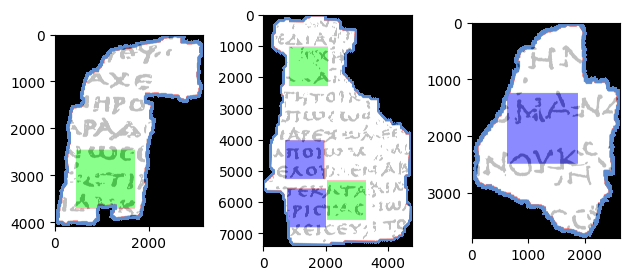

In [27]:
fig, ax = plt.subplots(1,3)
for i in range(len(DL.masks)):
    z = 1 - np.int16(GM_V[i])
    ax[i].imshow(z, cmap='brg', alpha = z * 0.6)
    z = 1 - np.int16(GM_t[i])
    ax[i].imshow(-z, cmap='brg', alpha = z * 0.6)
    z = 1 - np.int16(DL.labels[i])
    ax[i].imshow(z, cmap='gray', alpha = 0.25)
    z = np.int16(DL.masks[i])
    ax[i].imshow(z, cmap='gray', alpha = 1 - z)
fig.tight_layout()
#fig.savefig(this_model_path + 'valid_test_patches_tick.jpg')

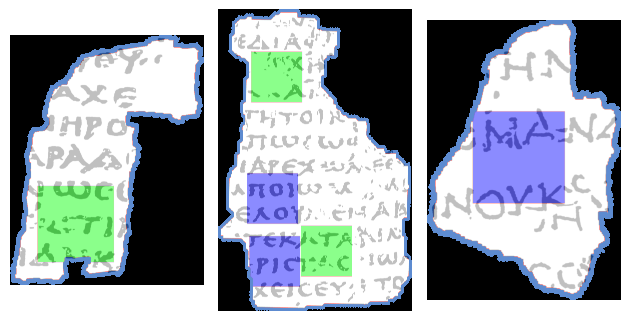

In [28]:
fig, ax = plt.subplots(1,3)
for i in range(len(DL.masks)):
    z = 1 - np.int16(GM_V[i])
    ax[i].imshow(z, cmap='brg', alpha = z * 0.6)
    z = 1 - np.int16(GM_t[i])
    ax[i].imshow(-z, cmap='brg', alpha = z * 0.6)
    z = 1 - np.int16(DL.labels[i])
    ax[i].imshow(z, cmap='gray', alpha = 0.25)
    z = np.int16(DL.masks[i])
    ax[i].imshow(z, cmap='gray', alpha = 1 - z)
    ax[i].axis("off")
fig.tight_layout()
fig.savefig(this_model_path + 'valid_test_patches.jpg')

#### Preparing Train Data Generator

In [29]:
if not 'enable_SliceShuffle' in globals():
    enable_SliceShuffle = False
if not 'enable_SliceRemove' in globals():
    enable_SliceRemove = False

In [30]:
GM = [GM_V[i] * GM_t[i] for i in range(len(GM_t))]
TG = Train_Data_Generator(DL, GM,
                          train_size=train_size, batch_size=batch_size,
                          aug=aug, iaa_aug=iaa_aug,
                          enable_SliceShuffle=enable_SliceShuffle,
                          enable_SliceRemove=enable_SliceRemove,
                          debug=False,
                          augmentation_rate=augmentation_rate,
                          random_training_set=random_training_set,
                          patch_selection_distance=patch_selection_distance,
                          train_per_epoch_propotion=train_per_epoch_propotion)

print(TG[0][0].shape)
print(TG[0][1].shape)
print(X_val.shape)
print(y_val.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 159/159 [00:00<00:00, 1902.82it/s]


(32, 96, 96, 24, 1)
(32, 96, 96, 1)
(121, 96, 96, 24, 1)
(121, 96, 96, 1)


##### Testing Data Augmentation

100%|████████████████████████████████████████████████████████████████████████████████| 140/140 [00:13<00:00, 10.28it/s]


It took about 13.62 seconds to generate training data for an epoch.
The mean Y of each training batch is 0.1681 +- 0.0393
The BCE baseline is 0.4529


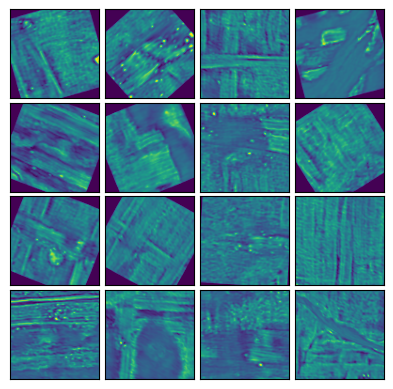

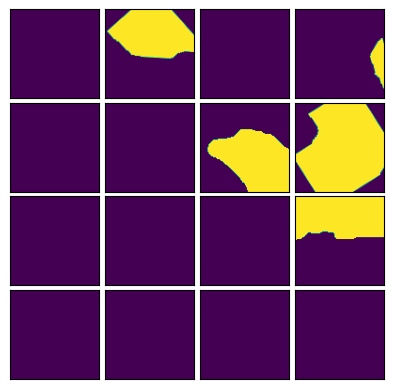

In [31]:
#  The approx time to generate the training data.
#if not running_mode == 'evaluate':
t0 = time.time()
mean_Ys = []
for i in tqdm(range(len(TG))):
    TG0X, TG0Y= TG[i]
    mean_Ys.append(np.mean(TG0Y))
t1 = time.time()
sec_used = t1 - t0
meanY = np.mean(mean_Ys)
stdY = np.std(mean_Ys)
bce_baseline = -(meanY*np.log(meanY) + (1 - meanY)*np.log(1 - meanY))
print(f'It took about {sec_used:.2f} seconds to generate training data for an epoch.')
print(f'The mean Y of each training batch is {meanY:.4f} +- {stdY:.4f}')
print(f'The BCE baseline is {bce_baseline:.4f}')

#  Check if the images and labels still match after data augmentation.
fig, axs = plt.subplots(4,4)
for i in range(16):
    this_ax = axs[int(i/4)][i%4]
    this_patch_idx = i
    if threeD_conv:
        this_ax.imshow(TG0X[this_patch_idx,:,:,0,0], vmin=0, vmax=1)
    else:
        this_ax.imshow(TG0X[this_patch_idx,:,:,0], vmin=0, vmax=1)

    this_ax.set_xticks([]); this_ax.set_yticks([])
plt.subplots_adjust(wspace=-0.55, hspace=0.05)

fig, axs = plt.subplots(4,4)
for i in range(16):
    this_ax = axs[int(i/4)][i%4]
    this_patch_idx = i
    this_ax.imshow(TG0Y[this_patch_idx,:,:,0],vmin=0, vmax=1)
    this_ax.set_xticks([]); this_ax.set_yticks([])
plt.subplots_adjust(wspace=-0.55, hspace=0.05)

## Training

### Callbacks

#### Custom Callbacks

In [32]:
class Custom_CallBack_ModelCheckPoint_BestTen(ModelCheckpoint):
    def __init__(self,
        filepath,
        monitor = 'val_Sorensen_Dice_coef',
        monitor_B = 'val_loss',
        verbose = 0,
        mode = 'max',
        mode_B = 'min',
        B_threshold_gap = 0.2,
        options = None,
        initial_value_threshold=None,
        early_stop = True,
        patience = 100,
        warm_up = 100,
        ten = 10,
        running_mode = 'new'
    ):
        super().__init__(filepath,
                        monitor = monitor,
                        verbose = verbose,
                        save_best_only = True,
                        save_weights_only = True,
                        mode = mode,
                        save_freq = "epoch",
                        options = options,
                        initial_value_threshold=initial_value_threshold)
        self.mode = mode
        self.monitor_B = monitor_B
        if self.monitor[0:4] == 'val_':
            self.train_monitor = self.monitor[4::]
        else:
            self.train_monitor = self.monitor
        self.train_monitor = self.monitor[4::]
        self.mode_B = mode_B
        self.B_threshold_gap = B_threshold_gap
        self.early_stop = early_stop
        self.patience = patience
        self.warm_up = warm_up
        self.ten = ten
        self.last_update_epoch = 0
        self.running_mode = running_mode
        
        if mode == 'max':
            self.best10 = [-np.Inf] * self.ten
        elif mode == 'min':
            self.best10 = [np.Inf] * self.ten
            
        if mode_B == 'max':
            self.best_B = -np.Inf
            self.monitor_op_B = np.greater
            self.threshold_B = self.bestB - self.B_threshold_gap
        elif mode_B == 'min':
            self.best_B = np.Inf
            self.monitor_op_B = np.less
            self.threshold_B = self.best_B + self.B_threshold_gap
    
    def _save_model(self, epoch, batch, logs):
        
        logs = logs or {}
        if (
            isinstance(self.save_freq, int)
            or self.epochs_since_last_save >= self.period
        ):
            # Block only when saving interval is reached.
            logs = tf_utils.sync_to_numpy_or_python_type(logs)
            self.epochs_since_last_save = 0
            filepath = self._get_file_path(epoch, batch, logs)

            # Create host directory if it doesn't exist.
            dirname = os.path.dirname(filepath)
            if dirname and not tf.io.gfile.exists(dirname):
                tf.io.gfile.makedirs(dirname)
            
            current_B = logs.get(self.monitor_B)
            if current_B is None:
                logging.warning(
                    "Can save best model only with %s available, "
                    "skipping.",
                    self.monitor_B,
                )
            else:
                if self.monitor_op_B(current_B, self.best_B):
                    self.best_B = current_B
                    if self.mode_B == 'max':
                        self.threshold_B = self.best_B - self.B_threshold_gap
                    elif self.mode_B == 'min':
                        self.threshold_B = self.best_B + self.B_threshold_gap
            print(f'Threshold B is {self.threshold_B:.4f}')
            
            log_keys = list(logs.keys())
            if self.monitor in log_keys:
                current = logs.get(self.monitor)
            else:
                currents = []
                for key in log_keys:
                    if 'val_' in self.monitor:
                        if 'val_' in key and self.monitor[4::] in key:
                            currents.append(logs.get(key))
                    else:
                        if self.monitor in key:
                            currents.append(logs.get(key))
                current = currents[-1]
            

            if current is None:
                logging.wthreshold_Ag(
                    "Can save best model only with %s available, "
                    "skipping.",
                    self.monitor,
                )
            else:
                if self.mode == 'max':
                    threshold_A = np.min(self.best10)
                    #print(f'Best A is {np.max(self.best10):.4f}.')
                    
                elif self.mode == 'min':
                    threshold_A = np.max(self.best10)
                    #print(f'Best A is {np.min(self.best10):.4f}.')
                
                print(f'The best {ten} are: ', end='')
                for i, j in enumerate(self.best10):
                    if i < self.ten-1:
                        print(f'{j:.6f}, ', end='')
                    else:
                        print(f'and {j:.6f}.')
                print(f'Threshold A is {threshold_A:.4f}.')
                
                if self.monitor_op(current, threshold_A):
                    if self.verbose > 0:
                        io_utils.print_msg(
                            f"\nEpoch {epoch + 1}: {self.monitor} "
                            "improved "
                            f"from {self.best:.5f} to {current:.5f}, "
                            f"saving model to {filepath}"
                        )
                    self.best = current
                    if self.monitor_op_B(current_B, self.threshold_B) and self._current_epoch >= self.warm_up/2:
                        if self.mode == 'max':
                            self.best10 = self.best10[1:self.ten] + [current]
                            self.best10 = list(np.sort(self.best10))
                        elif self.mode == 'min':
                            self.best10 = self.best10[0:self.ten-1] + [current]
                            self.best10 = list(np.sort(self.best10))
                        if self._current_epoch >= self.warm_up:
#                             if self.monitor_op_B(current_B, self.best10[int(self.ten/2)]): 
                            self.last_update_epoch = self._current_epoch
                            if not self.running_mode == 'optuna':
                                if self.save_weights_only:
                                    self.model.save_weights(
                                        filepath,
                                        overwrite=True,
                                        options=self._options,
                                    )
                                else:
                                    self.model.save(
                                        filepath,
                                        overwrite=True,
                                        options=self._options,
                                    )
                                print('Model weights saved!')
                else:
                    if self.verbose > 0:
                        io_utils.print_msg(
                            f"\nEpoch {epoch + 1}: "
                            f"{self.monitor} did not improve "
                            f"from {self.best:.5f}"
                        )
            early_stop_wait = \
            np.max((self._current_epoch - np.max((self.last_update_epoch, self.warm_up)), 0))
            print(f'Weights are saved at epoch {self.last_update_epoch} last time.')
            print(f'Early Stop Wait: {early_stop_wait}')
            if early_stop_wait >= self.patience and self.early_stop:
                current_train = logs.get(self.train_monitor)
                print([current, current_train])
                if self.monitor_op(current_train*1.2, threshold_A)\
                or self.monitor_op(current_train*0.8, threshold_A):
                    self.model.stop_training = True

In [33]:
class Custom_CallBack_LR_Modification(callbacks.Callback):
    def __init__(self,
        filepath,
        monitor="val_loss",
        factor=0.1,
        patience=10,
        verbose=0,
        mode="auto",
        min_delta=1e-4,
        cooldown=0,
        moving_mean_counts=100,
        min_lr=0,
        early_stop=True,
        early_stop_rate=1/1010.0,
        warm_up=10,
        **kwargs,
    ):
        super().__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.factor = factor
        self.min_lr = min_lr
        self.min_delta = min_delta
        self.patience = patience
        self.patience_B = patience * 2
        self.verbose = verbose
        self.cooldown = cooldown
        self.moving_mean_counts = moving_mean_counts
        self.cooldown_counter = 0  # Cooldown counter.
        self.reduce_rate = 1
        self.early_stop = early_stop
        self.early_stop_rate = early_stop_rate
        self.stream = []
        self.wait = 0
        self.best = 0
        self.mode = mode
        self.monitor_op = None
        self._reset()
        self.scheduled_lr = [[100, 10**(-3.5)], [250, 10**(-4)], [400, 10**(-4.5)], [500, 10**(-5)]]
        self.current_epoch = 0
        self.warm_up = warm_up
    
    def _Sigma_Mean(self, X, sigma=3, max_iter=100):
#         print(X)
        run = True
        iteration = 0
        this_X = np.array(X)
#         print(type(this_X))
#         print(this_X.shape)
        while run:
            previous_length = this_X.shape[0]
            mean = np.mean(this_X)
            std = np.std(this_X)
            if std > 0:
                sig = np.abs((this_X - mean)/std)
                this_X = this_X[sig < sigma]
                if this_X.shape[0] == previous_length or iteration >= max_iter-1:
                    run = False
                else:
                    iteration += 1
            else:
                run = False
        return mean
    
    def _moving_sigma_mean(self, X, n):
        m = X * 0.0
        for i in range(len(X)):
            if i < n:
                m[i] = self._Sigma_Mean(X[0:i+1])
            else:
                m[i] = self._Sigma_Mean(X[i-n:i])
        return m
    
    def _reset(self):
        """Resets wait counter and cooldown counter."""
        if self.mode not in ["auto", "min", "max"]:
            logging.warning(
                "Learning rate reduction mode %s is unknown, "
                "fallback to auto mode.",
                self.mode,
            )
            self.mode = "auto"
        if self.mode == "min" or (
            self.mode == "auto" and "acc" not in self.monitor
        ):
            self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
            self.best = np.Inf
        else:
            self.monitor_op = lambda a, b: np.greater(a, b + self.min_delta)
            self.best = -np.Inf
        self.cooldown_counter = 0
        self.wait = 0
    
    def in_cooldown(self):
        return self.cooldown_counter > 0
    
    def on_train_begin(self, logs=None):
        self._reset()
    
    def reduce_lr(self, new_lr, this_end, epoch):
        old_lr = K.get_value(self.model.optimizer.lr)
        self.best = this_end
        self.reduce_rate = self.reduce_rate / old_lr * new_lr
        if self.early_stop:
            if self.reduce_rate <= self.early_stop_rate:
                self.model.stop_training = True

        K.set_value(self.model.optimizer.lr, new_lr)
        #self.best = this_end
        with open(self.filepath+'lr.txt','w') as f:
            f.write(str(new_lr))
        if self.verbose > 0:
            io_utils.print_msg(
                f"\nEpoch {epoch +1}: "
                "ReduceLROnPlateau reducing "
                f"learning rate to {new_lr}."
            )
        self.cooldown_counter = self.cooldown
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch += 1
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.lr)
        current = logs.get(self.monitor)
        self.stream.append(current)
        #if len(self.stream) >= self.moving_mean_counts:
        if len(self.stream) >= self.warm_up:
            this_ma = self._moving_sigma_mean(np.array(self.stream), self.moving_mean_counts)
            this_end = this_ma[-1]
        else:
            this_end = self.best
            self.wait = 0
        
        if self.in_cooldown():
            self.cooldown_counter -= 1
            self.wait = 0

        if self.monitor_op(this_end, self.best):
            self.best = this_end
            self.wait = 0
        elif not self.in_cooldown():
            self.wait += 1
            if self.reduce_rate <= np.sqrt(self.early_stop_rate):
                this_patience = self.patience_B
            else:
                this_patience = self.patience
            if self.wait >= this_patience:
                old_lr = K.get_value(self.model.optimizer.lr)
                if old_lr > np.float32(self.min_lr):
                    new_lr = old_lr * self.factor
                    new_lr = max(new_lr, self.min_lr)
                    self.reduce_lr(new_lr, this_end, epoch)
        
        this_epoch = self.current_epoch
        this_lr = K.get_value(self.model.optimizer.lr)
        new_lr = this_lr
        for this_row in self.scheduled_lr:
            if this_epoch >= this_row[0] and this_lr > this_row[1]:
                new_lr = this_row[1]
        if new_lr < this_lr*0.999:
            new_lr = max(new_lr, self.min_lr)
            self.reduce_lr(new_lr, this_end, epoch)
        
        print(f'\nMoving Average of {self.monitor}: {this_end:.4f}, Best: {self.best:.4f}, Wait: {self.wait}')

#### Callbacks Setup

In [34]:
def reset_callbacks(check_point_patience=250,
                    check_point_warmup=30,
                    LR_patience=7,
                    LR_moving_mean_counts=50,
                    LR_warm_up=10,
                    save_freq=3200,
                    optuna=False,
                    optuna_str=''):
    checkpointA = callbacks.ModelCheckpoint(this_model_weight_path + 'model_weights_{epoch:05d}.h5',
                                        save_weights_only=True,
                                        save_freq=save_freq)
    checkpointB = callbacks.ModelCheckpoint(this_model_weight_path + 'best_loss_model_weights.h5',
                                            monitor='val_loss',
                                            save_best_only=True)
    checkpointC = callbacks.ModelCheckpoint(this_model_weight_path + 'best_dice_model_weights.h5',
                                            monitor='val_Sorensen_Dice_coef',
                                            save_best_only=True)
    if supervision:
        B_threshold_gap = 0.4 * block_num
    else:
        B_threshold_gap = 0.4
    checkpointD = \
        Custom_CallBack_ModelCheckPoint_BestTen(this_model_weight_path + 'best_model_' + \
                                                optuna_str + 'weights_{epoch:05d}.h5',
                                                early_stop=early_stop,
                                                patience=check_point_patience,
                                                B_threshold_gap=B_threshold_gap,
                                                warm_up=check_point_warmup,
                                                running_mode=running_mode,
                                                ten=ten)
    csvLogger = callbacks.CSVLogger(
        this_model_history_path + optuna_str + 'history.csv', append=True)
    ReduceLROnPlateau = callbacks.ReduceLROnPlateau(monitor='loss',
                                                    factor=np.sqrt(1/10),
                                                    patience=400,
                                                    verbose=1,
                                                    min_delta=0.000001)
    Custom_LR_Modification = Custom_CallBack_LR_Modification(filepath=this_model_path,
                                                             monitor='loss',
                                                             factor=np.sqrt(1/10),
                                                             verbose=1,
                                                             patience=LR_patience,
                                                             moving_mean_counts=LR_moving_mean_counts,
                                                             warm_up=0,
                                                             early_stop=True)
    earlystop = callbacks.EarlyStopping(monitor='val_loss',
                                        patience=500,
                                        restore_best_weights=True)
    
    return checkpointA, checkpointB, checkpointC, checkpointD, csvLogger, \
           ReduceLROnPlateau, Custom_LR_Modification, earlystop

In [35]:
if TG.train_size <= 10000:
    check_point_patience = 75
    check_point_warmup = 10
    LR_patience = 7
    LR_moving_mean_counts = 20
    LR_warm_up = 7
else:
    check_point_patience = 20
    check_point_warmup = 0
    LR_patience = 1
    LR_moving_mean_counts = 1
    LR_warm_up = 0
checkpointA, checkpointB, checkpointC, \
    checkpointD, csvLogger, \
    ReduceLROnPlateau, Custom_LR_Modification, \
    earlystop = reset_callbacks(check_point_patience=check_point_patience,
                                check_point_warmup=check_point_warmup,
                                LR_patience=LR_patience,
                                LR_moving_mean_counts=LR_moving_mean_counts,
                                LR_warm_up=LR_warm_up,
                                save_freq=int(np.round(3200/TG.batch_num))*TG.batch_num)
callbacks_L = [checkpointD, csvLogger, Custom_LR_Modification, checkpointA]

### Build Model

In [36]:
def create_model(dropout_factor=dropout_factor, L2_factor=L2_factor):
    if model_mode == 'UNET':
        model_module = UNET(threeD_conv=threeD_conv,
                            threeD_conv_range=threeD_conv_range,
                            block_num=block_num,
                            sub_layers=sub_layers,
                            res=res,
                            up_sample=up_sample,
                            multi_Resolution=multi_Resolution,
                            resolution_strides=resolution_strides,
                            conv_dropout=dropout_factor,
                            conv_dropout_0=dropout_factor,
                            dropout_factor=dropout_factor,
                            L2_factor=L2_factor,
                            filter_list=filter_list,
                            num_classes=num_classes,
                            y_process=y_process,
                            encoder=encoder,
                            transfer=transfer,
                            transfer_trainable=transfer_trainable,
                            depth_Fourier=depth_Fourier)
    elif model_mode == 'UNET_A':
        model_module = UNET_A(threeD_conv=threeD_conv,
                              threeD_conv_range=threeD_conv_range,
                              block_num=block_num,
                              sub_layers=sub_layers,
                              res=res,
                              up_sample=up_sample,
                              multi_Resolution=multi_Resolution,
                              resolution_strides=resolution_strides,
                              conv_dropout=dropout_factor,
                              conv_dropout_0=dropout_factor,
                              dropout_factor=dropout_factor,
                              L2_factor=L2_factor,
                              filter_list=filter_list,
                              num_classes=num_classes,
                              y_process=y_process,
                              encoder=encoder,
                              transfer=transfer,
                              transfer_trainable=transfer_trainable,
                              depth_Fourier=depth_Fourier)
    elif model_mode == 'UNET_plus':
        model_module = UNET_plus(threeD_conv=threeD_conv,
                                 threeD_conv_range=threeD_conv_range,
                                 block_num=block_num,
                                 sub_layers=sub_layers,
                                 res=res,
                                 up_sample=up_sample,
                                 multi_Resolution=multi_Resolution,
                                 resolution_strides=resolution_strides,
                                 conv_dropout=dropout_factor,
                                 conv_dropout_0=dropout_factor,
                                 dropout_factor=dropout_factor,
                                 L2_factor=L2_factor,
                                 filter_list=filter_list,
                                 num_classes=num_classes,
                                 y_process=y_process,
                                 encoder=encoder,
                                 transfer=transfer,
                                 transfer_trainable=transfer_trainable,
                                 supervision=supervision,
                                 depth_Fourier=depth_Fourier)
    elif model_mode == 'UNET_2plus':
        model_module = UNET_2plus(threeD_conv=threeD_conv,
                                  threeD_conv_range=threeD_conv_range,
                                  block_num=block_num,
                                  sub_layers=sub_layers,
                                  res=res,
                                  up_sample=up_sample,
                                  multi_Resolution=multi_Resolution,
                                  resolution_strides=resolution_strides,
                                  conv_dropout=dropout_factor,
                                  conv_dropout_0=dropout_factor,
                                  dropout_factor=dropout_factor,
                                  L2_factor=L2_factor,
                                  filter_list=filter_list,
                                  num_classes=num_classes,
                                  y_process=y_process,
                                  encoder=encoder,
                                  transfer=transfer,
                                  transfer_trainable=transfer_trainable,
                                  supervision=supervision,
                                  depth_Fourier=depth_Fourier)
    elif model_mode == 'UNET_3plus':
        model_module = UNET_3plus(threeD_conv=threeD_conv,
                             threeD_conv_range=threeD_conv_range,
                             block_num=block_num,
                             sub_layers=sub_layers,
                             res=res,
                             up_sample=up_sample,
                             multi_Resolution=multi_Resolution,
                             resolution_strides=resolution_strides,
                             conv_dropout=dropout_factor,
                             conv_dropout_0=dropout_factor,
                             dropout_factor=dropout_factor,
                             L2_factor=L2_factor,
                             filter_list=filter_list,
                             num_classes=num_classes,
                             y_process=y_process,
                             encoder=encoder,
                             transfer=transfer,
                             transfer_trainable=transfer_trainable,
                             supervision=supervision,
                             depth_Fourier=depth_Fourier)
    if threeD_conv:
        model = model_module.Build_Model((patch_size, patch_size, len(slices), 1))
    else:
        model = model_module.Build_Model((patch_size, patch_size, len(slices)))
        
    return model

In [37]:
if not running_mode == 'optuna':
    model = create_model(dropout_factor=dropout_factor, L2_factor=L2_factor)
    model.summary()
    utils.plot_model(model, to_file=this_model_path+'model.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 24,  0           []                               
                                 1)]                                                              
                                                                                                  
 average_pooling3d (AveragePool  (None, 48, 48, 24,   0          ['input_1[0][0]']                
 ing3D)                         1)                                                                
                                                                                                  
 average_pooling3d_1 (AveragePo  (None, 32, 32, 24,   0          ['input_1[0][0]']                
 oling3D)                       1)                                                            

                                                                                                  
 conv3d_2 (Conv3D)              (None, 48, 48, 16,   6928        ['dropout_1[0][0]']              
                                16)                                                               
                                                                                                  
 conv3d_5 (Conv3D)              (None, 32, 32, 16,   6928        ['dropout_28[0][0]']             
                                16)                                                               
                                                                                                  
 dropout_55 (Dropout)           (None, 24, 24, 16,   0           ['activation_55[0][0]']          
                                16)                                                               
                                                                                                  
 batch_nor

 conv2d_51 (Conv2D)             (None, 24, 24, 16)   2320        ['dropout_56[0][0]']             
                                                                                                  
 activation_4 (Activation)      (None, 48, 48, 16)   0           ['batch_normalization_4[0][0]']  
                                                                                                  
 activation_31 (Activation)     (None, 32, 32, 16)   0           ['batch_normalization_33[0][0]'] 
                                                                                                  
 batch_normalization_62 (BatchN  (None, 24, 24, 16)  64          ['conv2d_51[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_3 (Dropout)            (None, 48, 48, 16)   0           ['activation_4[0][0]']           
          

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 48, 48, 16)  64          ['conv2d_4[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_36 (BatchN  (None, 32, 32, 16)  64          ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_54 (Conv2D)             (None, 24, 24, 16)   2320        ['dropout_59[0][0]']             
                                                                                                  
 activation_7 (Activation)      (None, 48, 48, 16)   0           ['batch_normalization_7[0][0]']  
          

 ormalization)                                                                                    
                                                                                                  
 dropout_8 (Dropout)            (None, 24, 24, 128)  0           ['activation_9[0][0]']           
                                                                                                  
 dropout_35 (Dropout)           (None, 16, 16, 128)  0           ['activation_36[0][0]']          
                                                                                                  
 activation_63 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 24, 24, 16)   18448       ['dropout_8[0][0]']              
                                                                                                  
 conv2d_32

 conv2d_59 (Conv2D)             (None, 12, 12, 128)  147584      ['dropout_64[0][0]']             
                                                                                                  
 activation_12 (Activation)     (None, 24, 24, 128)  0           ['batch_normalization_12[0][0]'] 
                                                                                                  
 activation_39 (Activation)     (None, 16, 16, 128)  0           ['batch_normalization_41[0][0]'] 
                                                                                                  
 batch_normalization_70 (BatchN  (None, 12, 12, 128)  512        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_11 (Dropout)           (None, 24, 24, 128)  0           ['activation_12[0][0]']          
          

                                                                                                  
 conv2d_12 (Conv2D)             (None, 12, 12, 128)  147584      ['max_pooling2d_1[0][0]']        
                                                                                                  
 conv2d_37 (Conv2D)             (None, 8, 8, 128)    147584      ['max_pooling2d_4[0][0]']        
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 6, 6, 128)   0           ['dropout_67[0][0]']             
                                                                                                  
 batch_normalization_15 (BatchN  (None, 12, 12, 128)  512        ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 dropout_16 (Dropout)           (None, 12, 12, 128)  0           ['activation_17[0][0]']          
                                                                                                  
 dropout_43 (Dropout)           (None, 8, 8, 128)    0           ['activation_44[0][0]']          
                                                                                                  
 activation_71 (Activation)     (None, 6, 6, 128)    0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 12, 12, 128)  147584      ['dropout_16[0][0]']             
                                                                                                  
 conv2d_40

 conv2d_67 (Conv2D)             (None, 6, 6, 128)    147584      ['add_21[0][0]']                 
                                                                                                  
 activation_20 (Activation)     (None, 12, 12, 128)  0           ['batch_normalization_20[0][0]'] 
                                                                                                  
 activation_47 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_49[0][0]'] 
                                                                                                  
 batch_normalization_78 (BatchN  (None, 6, 6, 128)   512         ['conv2d_67[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_19 (Dropout)           (None, 12, 12, 128)  0           ['activation_20[0][0]']          
          

 conv2d_44 (Conv2D)             (None, 16, 16, 160)  23200       ['dropout_47[0][0]']             
                                                                                                  
 dropout_74 (Dropout)           (None, 12, 12, 16)   0           ['activation_75[0][0]']          
                                                                                                  
 batch_normalization_23 (BatchN  (None, 24, 24, 160)  640        ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_52 (BatchN  (None, 16, 16, 160)  640        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_69

                                                                                                  
 dropout_50 (Dropout)           (None, 16, 16, 16)   0           ['activation_51[0][0]']          
                                                                                                  
 activation_78 (Activation)     (None, 12, 12, 16)   0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 24, 24, 16)   2320        ['dropout_23[0][0]']             
                                                                                                  
 conv2d_47 (Conv2D)             (None, 16, 16, 16)   2320        ['dropout_50[0][0]']             
                                                                                                  
 dropout_77 (Dropout)           (None, 12, 12, 16)   0           ['activation_78[0][0]']          
          

                                                                                                  
 up_sampling2d_9 (UpSampling2D)  (None, 24, 24, 16)  0           ['dropout_79[0][0]']             
                                                                                                  
 concatenate_3 (Concatenate)    (None, 48, 48, 160)  0           ['concatenate_2[0][0]',          
                                                                  'up_sampling2d_2[0][0]']        
                                                                                                  
 concatenate_7 (Concatenate)    (None, 32, 32, 160)  0           ['concatenate_6[0][0]',          
                                                                  'up_sampling2d_6[0][0]']        
                                                                                                  
 concatenate_10 (Concatenate)   (None, 24, 24, 32)   0           ['up_sampling2d_9[0][0]',        
          

### Model Training

##### Uptuna Functions

In [38]:
def train_model(this_drop_factor, L2_factor):
    print(f'DropOut: {this_drop_factor:.4f}')
    print(f'Log of L2 factor: {-np.log10(L2_factor):.4f}')
    this_str = f'D{int(this_drop_factor*10000)}_L{int(-np.log10(L2_factor)*1000)}_'
    check_point_patience = 50
        
    if supervision:
        B_threshold_gap = 0.4 * block_num
    else:
        B_threshold_gap = 0.4
        
    if TG.train_size <= 10000:
        check_point_patience = check_point_patience
        check_point_warmup = 30
        LR_patience = 7
        LR_moving_mean_counts = 50
        LR_warm_up = 10
    else:
        check_point_patience = 20
        check_point_warmup = 0
        LR_patience = 1
        LR_moving_mean_counts = 1
        LR_warm_up = 0
    checkpointA, checkpointB, checkpointC, \
        checkpointD, csvLogger, \
        ReduceLROnPlateau, Custom_LR_Modification, \
        earlystop = reset_callbacks(check_point_patience=check_point_patience,
                                    check_point_warmup=check_point_warmup,
                                    LR_patience=LR_patience,
                                    LR_moving_mean_counts=LR_moving_mean_counts,
                                    LR_warm_up=LR_warm_up,
                                    optuna = True,
                                    optuna_str = this_str)
    callbacks_L = [checkpointD, csvLogger, Custom_LR_Modification]

    model = create_model(this_drop_factor, L2_factor)
    model.compile(optimizer=optimizers.Adam(),
                  loss=loss,
                  metrics=[Sorensen_Dice_coef, recall, precision, negative_precision])
    
    this_h = model.fit(TG, validation_data=(X_val_for_train, y_val_for_train),
                       epochs=epochs, verbose=2,
                       callbacks=callbacks_L)
    del model
    K.clear_session()
    if TG.train_size > 10000:
        v_dice = this_h.history['val_Sorensen_Dice_coef']
        sorted_v_dice = np.sort(v_dice)
        score = np.mean(sorted_v_dice[-5:-2])
    else:
        v_dice = this_h.history['val_Sorensen_Dice_coef'][10::]
        sorted_v_dice = np.sort(v_dice)
        score = np.mean(sorted_v_dice[-10:-5])
    return score

def finding_best_dropout_and_L2(trial):
    cfg = {'Log_L2_factor': trial.suggest_float('Log_L2_factor', -4, -0),
           'drop_factor': trial.suggest_float('drop_factor', 0.0, 0.4)}
    L2_factor = 10**cfg['Log_L2_factor']
    drop_factor = cfg['drop_factor']
    score = train_model(drop_factor, L2_factor)
    return score

#### Training

In [39]:
if loss_flag == 'binary_crossentropy':
    loss = 'binary_crossentropy'
elif loss_flag == 'hybrid_loss':
    loss = hybrid_loss
elif loss_flag == 'dice_loss':
    loss = dice_loss
elif loss_flag == 'Sorensen_Dice_loss':
    loss = Sorensen_Dice_loss

if running_mode == 'optuna':
    import optuna
    study_filename = this_model_path + 'study.pickle'

    sampler = optuna.samplers.TPESampler()
    if os.path.exists(study_filename):
        with open(study_filename, 'rb') as f:
            study = pickle.load(f)
    else:
        study = optuna.create_study(sampler=sampler, direction='maximize')

    study.optimize(finding_best_dropout_and_L2, n_trials=6)

    with open(study_filename, 'wb') as f:
        pickle.dump(study, f)

    
else:
    if not new_dir:
        try:
            weight_file = glob.glob(this_model_weight_path + 'model_weights*.h5')[-1]
            starting_epoch = int(weight_file.split('_')[-1][0:-3])
            model.load_weights(weight_file)
        except: 
            starting_epoch = 0

        historical_record = pd.read_csv(this_model_history_path + 'history.csv').iloc[0:starting_epoch]
        historical_record.to_csv(this_model_history_path + 'history.csv', index=False)
        
        try:
            lr_file = this_model_path + 'lr.txt'
            with open(lr_file, 'r') as f:
                lr = float(f.read())
        except:
            lr = 1e-3
    else:
        starting_epoch = 0
        lr = 1e-3
    
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=[Sorensen_Dice_coef, recall, precision, negative_precision])
    
    if not running_mode == 'evaluate':
        t0 = time.time()
#         this_h = model.fit(TG, validation_data = (X_val, y_val),
#                            epochs=epochs, initial_epoch=starting_epoch, verbose=2,
#                            callbacks=callbacks_L
#                           )
        this_h = model.fit(TG, validation_data = (X_val_for_train, y_val_for_train),
                           epochs=epochs, initial_epoch=starting_epoch, verbose=2,
                           callbacks=callbacks_L)
        
        t1 = time.time()
        duration = int(np.round((t1-t0)/60.0))
    else:
        duration = 'NA'

    this_history = pd.read_csv(this_model_history_path+'history.csv')
    del model
    K.clear_session()
    model = create_model(dropout_factor=dropout_factor, L2_factor=L2_factor)

    if not running_mode == 'evaluate':
        Q = len(this_history['loss'])
        model.save(this_model_weight_path + f'model_epoch{Q}.h5')

In [40]:
if running_mode == 'optuna':
    print(study.best_params['Log_L2_factor'])
    print(study.best_params['drop_factor'])
    
    this_dict = {'value':[], 'Log_L2_factor':[], 'drop_factor':[]}
    for trial in study.trials:
        try:
            this_dict['value'].append(trial.values[0])
            this_dict['Log_L2_factor'].append(trial.params['Log_L2_factor'])
            this_dict['drop_factor'].append(trial.params['drop_factor'])
        except:
            pass
    df = pd.DataFrame(this_dict)
    df = df.sort_values(by='value', ascending=False)
    df.to_csv(this_model_path + 'study.csv')
    print(df)
else:
    if not running_mode == 'evaluate':
        t1 = time.time()
        duration = int(np.round((t1-t0)/60.0))
    else:
        duration = 'NA'

    this_history = pd.read_csv(this_model_history_path+'history.csv')

    if not running_mode == 'evaluate':
        Q = len(this_history['loss'])
        model.save(this_model_weight_path + f'model_epoch{Q}.h5')

## Evaluations

### Miscellaneous Functions

#### Moving Average Methods

In [41]:
def moving_average(X, r):
    m = X * 0.0
    for i, j in enumerate(X):
        this_r = np.max([r, 1/(i+1)])
        if i == 0:
            m[i] = j
        else:
            if np.abs(np.log(j/m[i-1])) <= np.log(5):
                m[i] = m[i-1]*(1-this_r) + j*this_r
            else:
                m[i] = m[i-1]
    return m

def Sigma_Mean(X, sigma=3, max_iter=100):
    run = True
    iteration = 0
    this_X = np.array(X)
    while run:
        previous_length = this_X.shape[0]
        mean = np.mean(this_X)
        std = np.std(this_X)
        if std > 0:
            sig = np.abs((this_X - mean)/std)
            this_X = this_X[sig < sigma]
            if this_X.shape[0] == previous_length or iteration >= max_iter-1:
                run = False
            else:
                iteration += 1
        else:
            run = False
    return mean

def moving_sigma_mean(X, n):
    m = X * 0.0
    for i in range(len(X)):
        if i < n:
            m[i] = Sigma_Mean(X[0:i+1])
        else:
            m[i] = Sigma_Mean(X[i-n:i])
    return m

#### Evaluation Metrics

In [42]:
def Recall_for_ndarray(y_true, y_pred):
    epsilon = 1e-10
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    tp = np.mean(y_true_f * y_pred_f)
    fn = np.mean(y_true_f) - tp
    recall = (tp + epsilon) / (tp + fn + epsilon)
    return recall

def Precision_for_ndarray(y_true, y_pred):
    epsilon = 1e-10
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    tp = np.mean(y_true_f * y_pred_f)
    fp = np.mean(y_pred_f) - tp
    precision = (tp + epsilon) / (tp + fp + epsilon)
    
    return precision

def FP_rate_for_ndarray(y_true, y_pred):
    epsilon = 1e-10
    
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    tp = np.mean(y_true_f * y_pred_f)
    fp = np.mean(y_pred_f) - tp
    real_n = 1 - np.mean(y_true_f)
    fp_rate = (fp + epsilon) / (real_n + epsilon)
    
    return fp_rate
    
def Sorensen_Dice_coef_for_ndarray(y_true, y_pred):
    beta = 0.5
    epsilon = 1e-10
    
    p = Precision_for_ndarray(y_true, y_pred)
    r = Recall_for_ndarray(y_true, y_pred)
    
    coef = ((1 + beta**2) * p * r + epsilon) / ((beta**2) * p + r + epsilon)

    return coef

def area_under_curve(model, X_val, y_val):
    if supervision:
        y_pred = model.predict(X_val, verbose=0)[-1]
    else:
        y_pred = model.predict(X_val, verbose=0)
    thresholds = find_threshold_list(y_pred)[-1::-1]
    recalls = [0,]
    fp_rates = [0,]
    for i in range(100):
        this_threshold = thresholds[i]
        this_y = y_binarization(y_pred, this_threshold)
        recalls.append(Recall_for_ndarray(y_val, this_y))
        fp_rates.append(FP_rate_for_ndarray(y_val, this_y))
    
    recalls.append(1)
    fp_rates.append(1)
    AUC = 0
    for i in range(1,101):
        AUC += (fp_rates[i+1] - fp_rates[i-1])/2 * recalls[i]
    return AUC

#### Find Best Threshold

In [43]:
def find_threshold_list(y_pred):
    y_pred_sorted = np.sort(yt_pred.flatten())

    thresholds = []
    y_num = y_pred_sorted.shape[0]
    for i in range(100):
        thresholds.append(y_pred_sorted[int(y_num/100*(i+0.5))])
    
    return thresholds

def y_binarization(y, threshold):
    new_y = y * 0
    new_y[y >= threshold] = 1
    return new_y

def threholded_dice(y_val, y_pred, threshold):
    this_y_pred = y_binarization(y_pred, threshold)
    dice = float(Sorensen_Dice_coef(y_val, y_val-y_val+this_y_pred))
    
    return dice

def find_best_threshold(model, X_val, y_val):
    if supervision:
        y_pred = model.predict(X_val, verbose=0)[-1]
    else:
        y_pred = model.predict(X_val, verbose=0)
    thresholds = find_threshold_list(y_pred)
    Dice_after_threshold = []
    for i in range(100):
        this_threshold = thresholds[i]       
        dice = threholded_dice(y_val, y_pred, this_threshold)        
        Dice_after_threshold.append(dice)
    
    best_threshold = thresholds[np.argmax(Dice_after_threshold)]
    best_val_dice = np.max(Dice_after_threshold)
    averaged_val_dice = np.mean(Dice_after_threshold)
    
    return best_threshold, best_val_dice, averaged_val_dice

def thresholded_dice_over_samples(model, weight_path, X_list, y_list,
                                  given_threshold=None, combine_three_patch=False):
    def one_sample(model, X, y, given_threshold=given_threshold):
        if not given_threshold is None:
            best_threshold = given_threshold
            if supervision:
                y_pred = model.predict(X, verbose=0)[-1]
            else:
                y_pred = model.predict(X, verbose=0)
            best_val_dice = threholded_dice(y, y_pred, best_threshold)
            return best_threshold, best_val_dice
        else:
            best_threshold, best_val_dice, averaged_val_dice = find_best_threshold(model, X, y)
            return best_threshold, best_val_dice, averaged_val_dice
        
    
    model.load_weights(weight_path)
    BDs = []
    
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    if given_threshold is None:
        best_threshold, combined_dice, averaged_val_dice = one_sample(model, X, y)
    else:
        best_threshold, combined_dice = one_sample(model, X, y)
    
    for i in range(len(X_list)):
        this_X = X_list[i]
        this_y = y_list[i]
        _, best_dice = one_sample(model, this_X, this_y, given_threshold=best_threshold)
        BDs.append(best_dice)
    
    if combine_three_patch:
        if given_threshold is None:
            return BDs, best_threshold, averaged_val_dice, combined_dice
        else:
            return BDs, combined_dice
    else:
        if given_threshold is None:
            return BDs, best_threshold, averaged_val_dice
        else:
            return BDs


#### Ensemble Learning

In [44]:
def referendum_evaluation(weight_filenames, model, X, y=None, threshold=None):
    #    In this method, we take the average of the prediction over given weights first,
    #    then find the best threshold base on the averaged prediction.
    if (y is None) and (threshold is None):
        print(f'y and threshold can not be None at the same time.')
        print(f'The threshold is defined as 0.5 instead.')
        threshold = 0.5
    
    for i, this_weight_path in enumerate(weight_filenames):
        model.load_weights(this_weight_path)
        if supervision:
            this_pred = model.predict(X, verbose=0)[-1]
        else:
            this_pred = model.predict(X, verbose=0)
        if i == 0:
            y_pred = this_pred / len(weight_filenames)
        else:
            y_pred += this_pred / len(weight_filenames)
    
    if y is None:
        y_pred = y_binarization(y_pred, threshold)
        return y_pred

    if not threshold == None:
        best_threshold = threshold
        best_val_dice = threholded_dice(y, y_pred, threshold)
        y_pred = y_binarization(y_pred, threshold)
        best_val_dice_2 = Sorensen_Dice_coef_for_ndarray(y, y_pred)
        return best_threshold, best_val_dice, y_pred
    
    thresholds = find_threshold_list(y_pred)
    Dice_after_threshold = []
    for i in range(100):
        this_threshold = thresholds[i]
        dice = threholded_dice(y, y_pred, this_threshold)        
        Dice_after_threshold.append(dice)
    best_threshold = thresholds[np.argmax(Dice_after_threshold)]
    best_val_dice = np.max(Dice_after_threshold)
    averaged_val_dice = np.mean(Dice_after_threshold)
    return best_threshold, best_val_dice, averaged_val_dice, y_pred
    
    

In [45]:
def another_referendum_evaluation(weight_filenames, model, X, y=None, thresholds=None):
    #   In this method, we find the best thresholds and binary predictions for each weights individually first,
    #   then vote with these binary predictions.
    if (y is None) and (thresholds is None):
        print(f'y and thresholds can not be None at the same time.')
        print(f'The thresholds are defined as 0.5 instead.')
        thresholds = [0.5 for i in range(len(weight_filenames))]
    
    if not thresholds is None:
        known_thresholds = True
    else:
        known_thresholds = False
        thresholds = []
        
    y_preds = []
    Dice_after_threshold = []
    
    for i, this_weight_path in enumerate(weight_filenames):
        model.load_weights(this_weight_path)
        if supervision:
            this_ypred = model.predict(X, verbose=0)[-1]
        else:
            this_ypred = model.predict(X, verbose=0)
        if known_thresholds:
            best_threshold = thresholds[i]
            if not y is None:
                best_val_dice = threholded_dice(y, this_ypred, best_threshold)
            else:
                best_val_dice = None
        else:
            best_threshold, best_val_dice, averaged_val_dice = find_best_threshold(model, X, y)
            thresholds.append(best_threshold)
            
        Dice_after_threshold.append(best_val_dice)
        y_preds.append(y_binarization(this_ypred, best_threshold))
    
    idx = [*range(len(weight_filenames))]
    if len(weight_filenames) % 2 == 0:
        if y is None:
            idx = idx[0:-1]
        else:
            idx.remove(np.argmin(Dice_after_threshold))
        y_preds = [y_preds[i] for i in idx]
    
    referendum = sum(y_preds) / len(y_preds)    
    referendum = y_binarization(referendum, 0.5)
    if y is None:
        return referendum
    
    dice = Sorensen_Dice_coef_for_ndarray(y, referendum)
    return dice, idx, referendum

In [46]:
class Referendum_prediciton():
    def __init__(self, model_weight_path, epoch_list, model, vote_method, threshold):
        self.model_weight_path = model_weight_path
        self.epoch_list = epoch_list
        self.model = model
        self.vote_method = vote_method
        self.threshold = threshold
        self.weight_filenames = [model_weight_path + f'best_model_weights_{epoch:05d}.h5' for epoch in epoch_list]
        if self.vote_method == 'A':
            self.predict = self.referendum_predict_A
        elif self.vote_method == 'B':
            self.predict = self.referendum_predict_B
            
    def referendum_predict_A(self, X):
        #    In this method, we take the average of the prediction over given weights first,
        #    then find the best threshold base on the averaged prediction.

        for i, this_weight_path in enumerate(self.weight_filenames):
            self.model = re_build_model(model=self.model)
            self.model.load_weights(this_weight_path)
            this_pred = self.model.predict(X, verbose=1, batch_size=32)
            if i == 0:
                y_pred = this_pred / len(weight_filenames)
            else:
                y_pred += this_pred / len(weight_filenames)
                
        y_pred = y_binarization(y_pred, self.threshold)
        return y_pred
    
    def referendum_predict_B(self, X):
        #   In this method, we find the best thresholds 
        #   and binary predictions for each weights individually first,
        #   then vote with these binary predictions.
        y_preds = []
        if not type(self.threshold) == list:
            thresholds = [self.threshold for i in range(len(self.epoch_list))]
        else:
            thresholds = self.threshold

        for i, this_weight_path in enumerate(self.weight_filenames):
            self.model = re_build_model(model=self.model)
            self.model.load_weights(this_weight_path)
            this_pred = self.model.predict(X, verbose=1, batch_size=32)
            
            best_threshold = thresholds[i]
            y_preds.append(y_binarization(this_pred, best_threshold))

        idx = [*range(len(weight_filenames))]
        if len(weight_filenames) % 2 == 0:
            idx = idx[0:-1]
            y_preds = [y_preds[i] for i in idx]
        
        referendum = sum(y_preds) / len(y_preds)

        referendum = y_binarization(referendum, 0.5)
        return referendum        

Examples calling Referendum_prediciton methods

#### Plot Comparison Between Truth and Prediction

In [82]:
def Y_prediction_truth_plot(patch_range, y_pred, y_truth, threshold=0.5):
    ixs = np.array(patch_range)[:,0]
    iys = np.array(patch_range)[:,2]

    ixs -= np.min(ixs)
    iys -= np.min(iys)

    ixs = [int(i/patch_size) for i in ixs]
    iys = [int(i/patch_size) for i in iys]
    
    modified_YPred = y_binarization(y_pred, threshold)
    
    fig, ax = plt.subplots(np.max(iys)+1,np.max(ixs)+1)
    plot_idxs = np.zeros((np.max(iys)+1,np.max(ixs)+1))
    for i in range(len(ixs)):
        ax[iys[i]][ixs[i]].imshow(modified_YPred[i][:,:,0], cmap='gray',vmin=0, vmax=1)
        ax[iys[i]][ixs[i]].imshow(y_truth[i][:,:,0], cmap='winter',vmin=0, vmax=1, alpha=0.5)
        ax[iys[i]][ixs[i]].set_xticks([]); ax[iys[i]][ixs[i]].set_yticks([])
        plot_idxs[iys[i], ixs[i]] = 1
    for i in range(np.max(iys)+1):
        for j in range(np.max(ixs)+1):
            if plot_idxs[i, j] == 0:
                v = np.zeros((patch_size, patch_size))+0.5
                ax[i][j].imshow(v, cmap='gray',vmin=0, vmax=1)
                ax[i][j].set_xticks([]); ax[i][j].set_yticks([])

    plt.subplots_adjust(wspace=-0.05, 
                        hspace=0.05)
    fig.set_size_inches((6, 6))
    
    return fig, ax

### Show Loss and Dice History

Best validation loss is 0.6505 at the 171th epoch.
Best validation dice is 0.3902 at the 171th epoch.


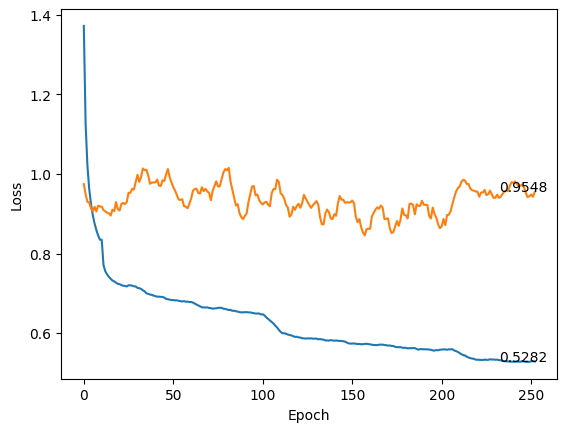

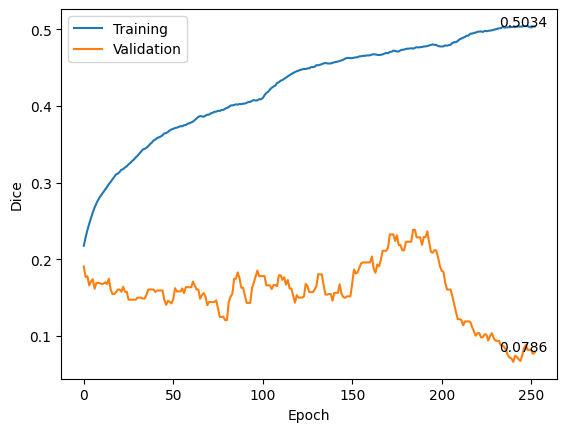

In [48]:
if not running_mode == 'optuna':
    if supervision:
        H_loss = np.array(this_history['loss'])
        H_val_loss = np.array(this_history['val_loss'])
        H_dice = np.array(this_history[this_history.keys()[block_num*2-1]])
        H_val_dice = np.array(this_history[this_history.keys()[block_num*4]])
    else:
        H_loss = np.array(this_history['loss'])
        H_val_loss = np.array(this_history['val_loss'])
        H_dice = np.array(this_history['Sorensen_Dice_coef'])
        H_val_dice = np.array(this_history['val_Sorensen_Dice_coef'])

    total_epochs = H_loss.shape[0]
    
    if TG.train_size >= 10000:
        N = 1
    else:
        N = 10
    
    fig, ax = plt.subplots()
    y0 = list(moving_sigma_mean(H_loss,N))
    y1 = list(moving_sigma_mean(H_val_loss,N))
    x = np.arange(len(y0))
    ax.plot(x, y0, label='Training')
    ax.plot(x, y1, label='Validation')
    ax.annotate(f'{y0[-1]:.4f}', xy=(x[-1],y0[-1]), xytext=(x[-1]*0.92,y0[-1]+0.001))
    ax.annotate(f'{y1[-1]:.4f}', xy=(x[-1],y1[-1]), xytext=(x[-1]*0.92,y1[-1]+0.001))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    #ax.set_ylim(0.3,0.7)
    fig.savefig(this_model_path + 'Loss.jpg')
    
    fig, ax = plt.subplots()
    y0 = list(moving_average(np.array(H_dice),1.0/N))
    y1 = list(moving_average(np.array(H_val_dice),1.0/N))
    x = np.arange(len(y0))
    ax.plot(x, y0, label='Training')
    ax.plot(x, y1, label='Validation')
    ax.annotate(f'{y0[-1]:.4f}', xy=(x[-1],y0[-1]), xytext=(x[-1]*0.92,y0[-1]+0.001))
    ax.annotate(f'{y1[-1]:.4f}', xy=(x[-1],y1[-1]), xytext=(x[-1]*0.92,y1[-1]+0.001))
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Dice')
    ax.legend()
    fig.savefig(this_model_path + 'Dice.jpg')
    
    best_val_loss = np.min(H_val_loss)
    best_epoch = np.argmin(H_val_loss)
    print(f'Best validation loss is {best_val_loss:.4f} at the {best_epoch}th epoch.')

    best_dice_loss = np.max(H_val_dice)
    best_epoch = np.argmax(H_val_dice)
    print(f'Best validation dice is {best_dice_loss:.4f} at the {best_epoch}th epoch.')

### The Histogram of the predicted values

[0.32260561 0.33843851 0.35027418 0.35065937 0.35916185 0.37891746
 0.39019719]
[181, 95, 152, 85, 82, 185, 172]
[0.7152466177940369, 0.7134819626808167, 0.6864439249038696, 0.7007492780685425, 0.7073683142662048, 0.6581611037254333, 0.6504702568054199]
0.0509 of predicted results greater than 0.9999.
0.8695 of predicted results lesser than 0.0001.
0.0796 of predicted results in between.


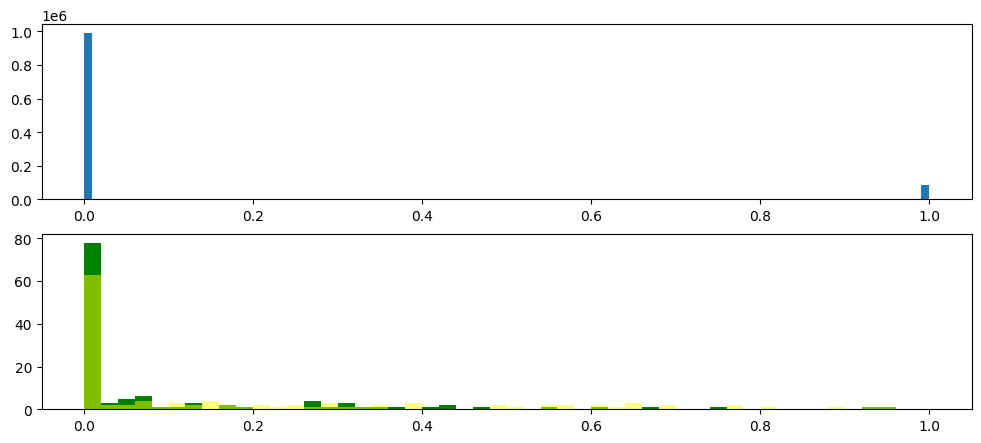

In [49]:
 if not running_mode == 'optuna':
    best_flie_list = glob.glob(this_model_weight_path + 'best_model*.h5')
    candidate_epochs = [int(s.split('.')[1].split('_')[-1])
                        for s in best_flie_list]

    candidate_dice = [H_val_dice[i-1] for i in candidate_epochs]
    # candidate_loss = [H_val_loss[i-1] for i in candidate_epochs]

    dice_values = np.sort(candidate_dice)[-ten::]
    elected_epochs = [-1]*ten
    for i, dice in enumerate(candidate_dice):
        for j in range(len(dice_values)):
            if dice == dice_values[j]:
                elected_epochs[j] = candidate_epochs[i]
                pass
    elected_epochs = elected_epochs[0:len(dice_values)]
    loss_values = [H_val_loss[i-1] for i in elected_epochs]
    num_elected = len(dice_values)
    print(dice_values)
    print(elected_epochs)
    print(loss_values)

    Winner = np.random.randint(num_elected)
    this_weight_path = this_model_weight_path + f'best_model_weights_{elected_epochs[Winner]:05d}.h5'
    model.load_weights(this_weight_path)
    
    if supervision:
        yt_pred = model.predict(X_val, verbose=0)[-1]
    else:
        yt_pred = model.predict(X_val, verbose=0)
    
    G99 = np.where(yt_pred>0.9999)[0].shape[0]/np.prod(yt_pred.shape)
    L01 = np.where(yt_pred<0.0001)[0].shape[0]/np.prod(yt_pred.shape)
    in_between = 1 - G99 - L01
    print(f'{G99:.4f} of predicted results greater than 0.9999.')
    print(f'{L01:.4f} of predicted results lesser than 0.0001.')
    print(f'{in_between:.4f} of predicted results in between.')
    
    fig, ax = plt.subplots(2,1)
    ax[0].hist(np.reshape(yt_pred, (-1,1)),100)
    ax[1].hist(np.mean(yt_pred, axis=(1, 2, 3)), 50, (0, 1), color = 'green')
    ax[1].hist(np.mean(y_val, axis=(1, 2, 3)), 50, (0, 1), alpha=0.5, color = 'yellow')

    fig.set_size_inches((12, 5))
    fig.savefig(this_model_path + 'hist.jpg')

### The Champions out of the Best 10

In [50]:
def re_build_model(model=model):
    del model
    K.clear_session()
    model = create_model(dropout_factor=dropout_factor, L2_factor=L2_factor)
    return model

In [51]:
def go_through_epochs(model, elected_epochs, X, y, thresholds=None):
    best_weight_path = ''
    best_mean_dice = -np.Inf
    goat_threshold = 0
    if thresholds is None:
        known_threshold = False
        best_thresholds_for_each_weights = []
    else:
        known_threshold = True
        best_thresholds_for_each_weights = thresholds

    for i, epoch in enumerate(elected_epochs):
        this_weight_path = this_model_weight_path + \
            f'best_model_weights_{epoch:05d}.h5'
        if known_threshold:
            best_threshold = best_thresholds_for_each_weights[i]
            best_val_dices = thresholded_dice_over_samples(model, this_weight_path,
                                                           X, y,
                                                           given_threshold=best_threshold)
        else:
            best_val_dices, best_threshold, averaged_val_dice = \
                thresholded_dice_over_samples(model, this_weight_path,
                                              X, y,
                                              combine_three_patch=False)
        this_mean_dice = np.mean(best_val_dices)
        best_thresholds_for_each_weights.append(best_threshold)
        if this_mean_dice > best_mean_dice:
            best_mean_dice = this_mean_dice
            best_weight_path = this_weight_path
            goat_threshold = best_threshold
        print(f'Epoch: {epoch}')
        print(f'Best Threshold for this weights: {best_threshold:.5f}')
        print('The dice for patches with given threshold:')
        print(best_val_dices)
        print(f'The mean value of dices above: {this_mean_dice:.4f}')
        print('='*30)
    return best_thresholds_for_each_weights, best_weight_path, best_mean_dice, goat_threshold

In [52]:
if not running_mode == 'optuna':
    model = re_build_model(model=model)
    best_thresholds_for_each_weights, best_weight_path, best_mean_dice, goat_threshold = \
    go_through_epochs(model, elected_epochs, X_val_for_train_list, y_val_for_train_list)
    best_single_epoch = int(best_weight_path[-8:-3])
    print('The path of best weight:')
    print(best_weight_path)
    print(f'The best epoch: {best_single_epoch}')
    print(f'The best threshold for the weight above: {goat_threshold:.5f}')
    print(f'The best dice from single weight: {best_mean_dice:.4f}')

    weight_filenames = [this_model_weight_path +
                        f'best_model_weights_{epoch:05d}.h5' for epoch in elected_epochs]
    R_best_threshold, R_best_dice, R_averaged_val_dice, yp0 = \
        referendum_evaluation(weight_filenames, model,
                              X_val_for_train, y=y_val_for_train)
    print('=' * 50)
    print('The first way of ensemble learning over diff weights')
    print('-' * 50)
    print(f'The best threshold: {R_best_threshold:.4f}')
    print(f'The best Dice: {R_best_dice:.4f}')
    print('=' * 50)

    R2_best_dice, eff_idx, referendum = another_referendum_evaluation(weight_filenames, model,
                                                                      X_val_for_train, y=y_val_for_train,
                                                                      thresholds=best_thresholds_for_each_weights)
    the_epochs_for_R2 = [elected_epochs[i] for i in eff_idx]
    the_thresholds_for_R2 = [best_thresholds_for_each_weights[i] for i in eff_idx]

    print('=' * 50)
    print('The second way of ensemble learning over diff weights')
    print('-' * 50)
    print(f'The best Dice: {R2_best_dice:.4f}')
    for i in range(len(the_epochs_for_R2)):
        print(f'Epoch: {the_epochs_for_R2[i]}, Threshold: {the_thresholds_for_R2[i]:.5f}')
    print('=' * 50)

Epoch: 181
Best Threshold for this weights: 0.00005
The dice for patches with given threshold:
[0.5741705684792681, 0.2930124133518115, 0.5061670845726449]
The mean value of dices above: 0.4578
Epoch: 95
Best Threshold for this weights: 1.00000
The dice for patches with given threshold:
[0.4498274757138549, 0.22213508580410468, 0.4046757728299207]
The mean value of dices above: 0.3589
Epoch: 152
Best Threshold for this weights: 0.00246
The dice for patches with given threshold:
[0.5630247667109276, 0.31559644530931136, 0.5493686159935546]
The mean value of dices above: 0.4760
Epoch: 85
Best Threshold for this weights: 0.99997
The dice for patches with given threshold:
[0.4215232974176617, 0.38288556414020436, 0.4222238945695086]
The mean value of dices above: 0.4089
Epoch: 82
Best Threshold for this weights: 0.99997
The dice for patches with given threshold:
[0.406077732382586, 0.387033203060827, 0.44287044842969103]
The mean value of dices above: 0.4120
Epoch: 185
Best Threshold for t

In [53]:
if not running_mode == 'optuna':
    model = re_build_model(model=model)
    _, best_weight_path_test, best_mean_dice_test, goat_threshold_test = \
        go_through_epochs(model, elected_epochs, X_test_list, y_test_list,
                          thresholds=best_thresholds_for_each_weights)

    print('The path of best weight:')
    print(best_weight_path_test)
    print(
        f'The best threshold for the weight above: {goat_threshold_test:.5f}')
    print(f'The best dice from single weight: {best_mean_dice_test:.4f}')

    R_best_threshold_test, R_best_dice_test, _ = \
        referendum_evaluation(weight_filenames, model,
                              X_test, y=y_test, threshold=R_best_threshold)
    print('=' * 50)
    print('The first way of ensemble learning over diff weights')
    print('-' * 50)
    print(f'The best threshold: {R_best_threshold_test:.4f}')
    print(f'The best Dice: {R_best_dice_test:.4f}')
    print('=' * 50)

    R2_weight_filenames = [weight_filenames[i] for i in eff_idx]
    R2_best_dice_test, __, ___ = another_referendum_evaluation(R2_weight_filenames, model,
                                                             X_test, y=y_test,
                                                             thresholds=the_thresholds_for_R2)

    print('=' * 50)
    print('The second way of ensemble learning over diff weights')
    print('-' * 50)
    print(f'The best Dice: {R2_best_dice_test:.4f}')
    print('=' * 50)

Epoch: 181
Best Threshold for this weights: 0.00005
The dice for patches with given threshold:
[0.13428871955927574, 0.6286441855084342, 0.7147823353195335]
The mean value of dices above: 0.4926
Epoch: 95
Best Threshold for this weights: 1.00000
The dice for patches with given threshold:
[0.382432700742464, 0.5073474502262507, 0.6630450930680206]
The mean value of dices above: 0.5176
Epoch: 152
Best Threshold for this weights: 0.00246
The dice for patches with given threshold:
[0.1881087727527308, 0.6351346263567428, 0.7452529300145295]
The mean value of dices above: 0.5228
Epoch: 85
Best Threshold for this weights: 0.99997
The dice for patches with given threshold:
[0.3143689574531739, 0.4550633373370341, 0.5201279762826406]
The mean value of dices above: 0.4299
Epoch: 82
Best Threshold for this weights: 0.99997
The dice for patches with given threshold:
[0.3310964073303142, 0.4737997976722949, 0.6295382274602939]
The mean value of dices above: 0.4781
Epoch: 185
Best Threshold for thi

### Saving Record

In [54]:
if not running_mode == 'optuna':
    best_dice = np.mean([R_best_dice_test, R2_best_dice_test]) 

#     print(f'Best Threshold: {best_threshold}')
#     print(f'Best Validation Dice: {best_val_dices}')
#     print(f'Results of the old referendum law: {[R_best_val_dice, R2_best_val_dice, R3_best_val_dice]}')
#     print(f'Results of the new referendum law: {all_the_dice}')
#     print(f'Best Dice: {best_dice}')

    dict_to_df = copy.deepcopy(initial_parameters)
    if 'xray_patches' in dict_to_df.keys():
        dict_to_df.pop('xray_patches')
    if 'validation_choice' in dict_to_df.keys():
        dict_to_df.pop('validation_choice')
    if 'test_choice' in dict_to_df.keys():
        dict_to_df.pop('test_choice')
    if 'slices' in dict_to_df.keys():
        dict_to_df['slices'] = str(dict_to_df['slices'])
    if 'filter_list' in dict_to_df.keys():
        dict_to_df['filter_list'] = str(dict_to_df['filter_list'])
    if 'expand_sample_2d' in dict_to_df.keys():
        dict_to_df['expand_sample_2d'] = str(dict_to_df['expand_sample_2d'])
    if 'resolution_strides' in dict_to_df.keys():
        dict_to_df['resolution_strides'] = str(dict_to_df['resolution_strides'])

    this_df = pd.DataFrame(dict_to_df, index=[0])
    date_str = this_model_path.split('/')[1][0:10]
#     if not new_dir:
#         date_str = old_path.split('/')[1][0:10]
    this_df['date'] = date_str
    this_df.insert(0, 'best_val_dice', best_dice)
    this_df.insert(1, 'best_epoch', best_epoch)
    this_df.insert(2, 'best_val_loss', best_val_loss)
    #this_df.insert(3, 'averaged_val_dice', averaged_val_dice)
    this_df.insert(this_df.shape[1], 'epochs', total_epochs)
    this_df.insert(this_df.shape[1], 'duration', duration)

    df_filename = f'2024_leaderboard_{model_mode}_slice_select.csv'
    if os.path.exists(df_filename):
        df = pd.read_csv(df_filename, )
        df = pd.concat([df, this_df], axis=0, ignore_index=True)
        df = df.sort_values(by='best_val_dice', ascending=False)
    else:
        df = this_df
    df.to_csv(df_filename, index=False)

In [55]:
if not running_mode == 'optuna':
    operation_parameters = {
        'best_single_epoch': best_single_epoch,
        'best_single_threshold': goat_threshold,
        'R_best_threshold': R_best_threshold,
        'elected_epochs': elected_epochs,
        'epochs_for_R2': the_epochs_for_R2,
        'thresholds_for_R2': the_thresholds_for_R2,
        'validation_patches': [[VG.img_choice, VG.mx, VG.my] for VG in VGs],
        'test_patches': [[tG.img_choice, tG.mx, tG.my] for tG in test_Gs],
    }
    with open(this_model_path + 'operation_parameters.pickle', 'wb') as f:
        pickle.dump(operation_parameters, f)

### Illustration of Prediction and Ground Truth

In [56]:
def remake_predict_func(model):
    Rp = Referendum_prediciton(this_model_weight_path, 
                           elected_epochs, model,
                           'B', R_best_threshold)
    predict_func = Rp.predict
    return predict_func

In [83]:
def Prediction_and_comparison_with_referendum(data_gens,
                                              X_list, y_truth_list,
                                              predict_func,
                                              y_pred_list=[],
                                              patch_type='Validation'):
    for i in range(len(data_gens)):
        G = data_gens[i]
        X = X_list[i]
        y_truth = y_truth_list[i]

        y_pred = predict_func(X)
        y_pred_list.append(y_pred)

        fig, ax = Y_prediction_truth_plot(patch_range=G.validation_patch_range,
                                          y_pred=y_pred,
                                          y_truth=y_truth)
        fig.suptitle(f'{patch_type} Patch {i+1}')
        fig.savefig(this_model_path + f'Ink_Prediction_{patch_type[0]}{i}.jpg')

    return y_pred_list

4/4 [==============================] - 1s 106ms/step


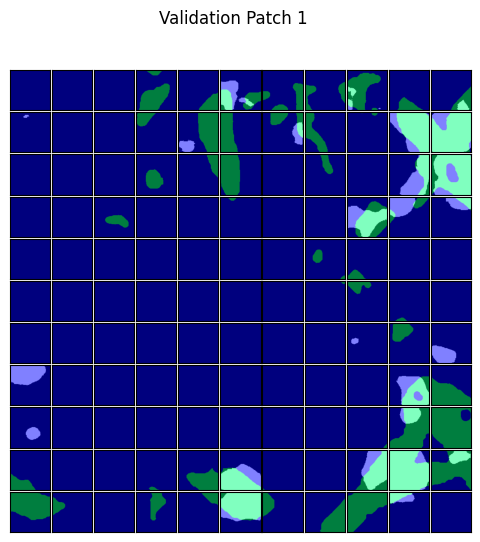

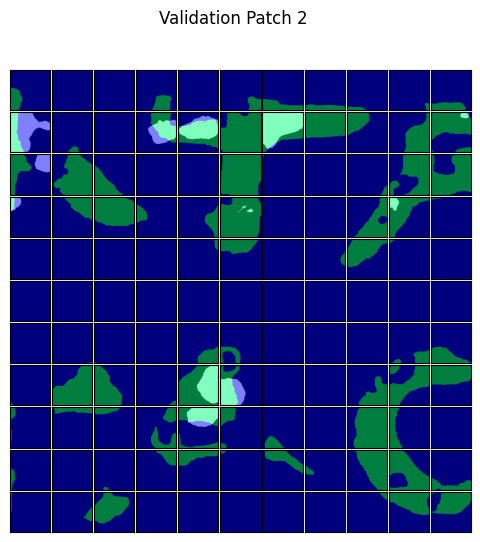

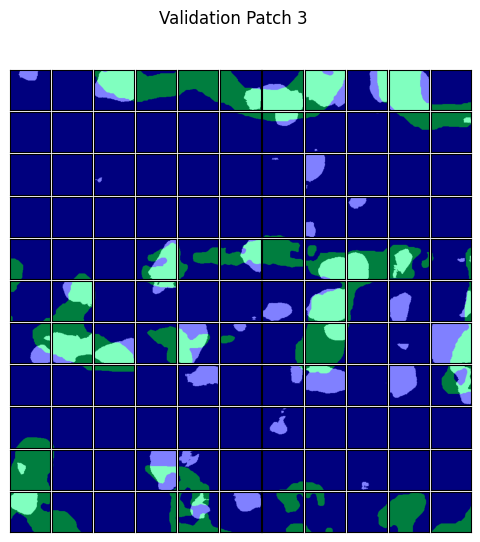

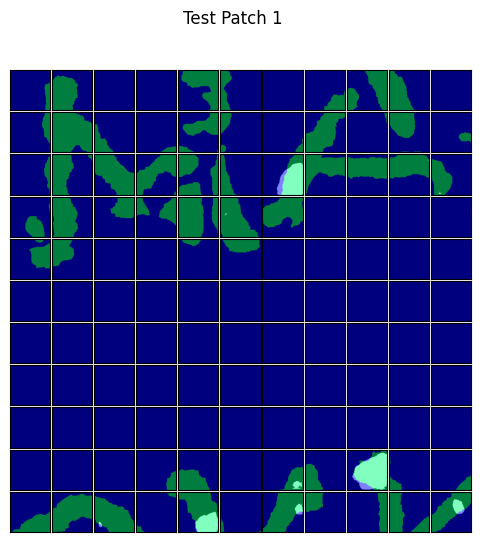

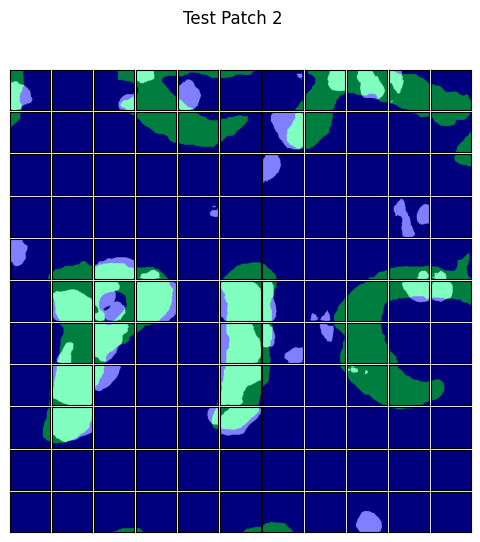

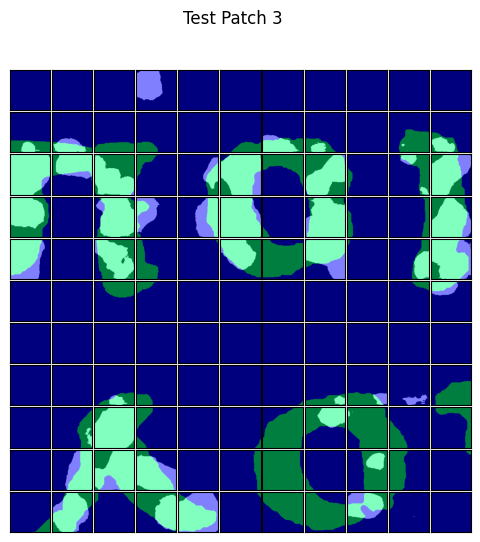

In [84]:
if not running_mode == 'optuna':
    predict_func = remake_predict_func(model)
    weight_filenames = [this_model_weight_path +
                        f'best_model_weights_{epoch:05d}.h5' for epoch in elected_epochs]

    y_truth_list = y_val_for_train_list
    X_list = X_val_for_train_list
    data_gens = VGs
    y_pred_list = Prediction_and_comparison_with_referendum(data_gens,
                                                            X_list, y_truth_list,
                                                            predict_func=predict_func,
                                                            patch_type='Validation')

    y_truth_list = y_test_list
    X_list = X_test_list
    data_gens = test_Gs
    y_pred_list = Prediction_and_comparison_with_referendum(data_gens,
                                                            X_list, y_truth_list,
                                                            predict_func=predict_func,
                                                            y_pred_list=y_pred_list,
                                                            patch_type='Test')

In [75]:
metric_dict = {'Patch': [],
               'Recall': [],
               'Precision': [],
               'Dice': []}

YT_list = []
YP_list = []
for i in range(len(y_val_for_train_list)):
    y_true = y_val_for_train_list[i]; y_pred = y_pred_list[i]
    
    YT_list.append(y_true)
    YP_list.append(y_pred)
    
    recall = Recall_for_ndarray(y_true, y_pred)
    precision = Precision_for_ndarray(y_true, y_pred)
    dice = Sorensen_Dice_coef_for_ndarray(y_true, y_pred)
    
    metric_dict['Patch'].append(f'V{i+1}')
    metric_dict['Recall'].append(recall)
    metric_dict['Precision'].append(precision)
    metric_dict['Dice'].append(dice)

YT = np.concatenate(YT_list, axis=0)
YP = np.concatenate(YP_list, axis=0)
recall = Recall_for_ndarray(YT, YP)
precision = Precision_for_ndarray(YT, YP)
dice = Sorensen_Dice_coef_for_ndarray(YT, YP)

metric_dict['Patch'].append('ALL_V')
metric_dict['Recall'].append(recall)
metric_dict['Precision'].append(precision)
metric_dict['Dice'].append(dice)

YT_list = []
YP_list = []
for i in range(len(y_test_list)):
    y_true = y_test_list[i]; y_pred = y_pred_list[i + len(y_val_for_train_list)]
    
    YT_list.append(y_true)
    YP_list.append(y_pred)
    
    recall = Recall_for_ndarray(y_true, y_pred)
    precision = Precision_for_ndarray(y_true, y_pred)
    dice = Sorensen_Dice_coef_for_ndarray(y_true, y_pred)
    
    metric_dict['Patch'].append(f'T{i+1}')
    metric_dict['Recall'].append(recall)
    metric_dict['Precision'].append(precision)
    metric_dict['Dice'].append(dice)

YT = np.concatenate(YT_list, axis=0)
YP = np.concatenate(YP_list, axis=0)
recall = Recall_for_ndarray(YT, YP)
precision = Precision_for_ndarray(YT, YP)
dice = Sorensen_Dice_coef_for_ndarray(YT, YP)

metric_dict['Patch'].append('ALL_T')
metric_dict['Recall'].append(recall)
metric_dict['Precision'].append(precision)
metric_dict['Dice'].append(dice)

In [76]:
ensemble_df = pd.DataFrame(metric_dict)
ensemble_df

,Patch,Recall,Precision,Dice
0,V1,0.374050,0.670511,0.578768
1,V2,0.105786,0.715687,0.332401
2,V3,0.387228,0.572577,0.522553
3,ALL_V,0.276384,0.623381,0.498267
4,T1,0.061725,0.897984,0.242068
5,T2,0.408972,0.710773,0.619362
6,T3,0.525539,0.819538,0.737071
7,ALL_T,0.367295,0.780646,0.637221


### Investigate Weight Distribution

Layer name: input_1
Layer Index: 0
Layer name: average_pooling3d
Layer Index: 1
Layer name: average_pooling3d_1
Layer Index: 2
Layer name: conv3d
Layer Index: 3
0.292421817779541
0.009381936863064766
Layer name: conv3d_3
Layer Index: 4
0.03743783012032509
0.00012977159349247813
Layer name: average_pooling3d_2
Layer Index: 5
Layer name: batch_normalization
Layer Index: 6
1.5830340385437012
0.38840508460998535
Layer name: batch_normalization_29
Layer Index: 7
1.159273624420166
0.13751471042633057
Layer name: conv3d_6
Layer Index: 8
0.039512865245342255
0.00015107609215192497
Layer name: activation
Layer Index: 9
Layer name: activation_27
Layer Index: 10
Layer name: batch_normalization_58
Layer Index: 11
1.1872531175613403
0.12107747793197632
Layer name: dropout
Layer Index: 12
Layer name: dropout_27
Layer Index: 13
Layer name: activation_54
Layer Index: 14
Layer name: conv3d_1
Layer Index: 15
0.40416190028190613
1.930750295286998e-05
Layer name: conv3d_4
Layer Index: 16
0.041535124182701

7.775746269089723e-08
Layer name: activation_13
Layer Index: 180
Layer name: activation_40
Layer Index: 181
Layer name: batch_normalization_71
Layer Index: 182
1.2013399600982666
0.26319852471351624
Layer name: dropout_12
Layer Index: 183
Layer name: dropout_39
Layer Index: 184
Layer name: activation_67
Layer Index: 185
Layer name: add_3
Layer Index: 186
Layer name: add_11
Layer Index: 187
Layer name: dropout_66
Layer Index: 188
Layer name: conv2d_11
Layer Index: 189
0.03841486573219299
1.5275868747721688e-07
Layer name: conv2d_36
Layer Index: 190
0.00927172601222992
1.4599751629873481e-08
Layer name: add_19
Layer Index: 191
Layer name: batch_normalization_14
Layer Index: 192
2.5252413749694824
0.41733530163764954
Layer name: batch_normalization_43
Layer Index: 193
1.1729415655136108
0.3241276443004608
Layer name: conv2d_61
Layer Index: 194
0.012960847467184067
5.610244357967531e-08
Layer name: activation_14
Layer Index: 195
Layer name: activation_41
Layer Index: 196
Layer name: batch_

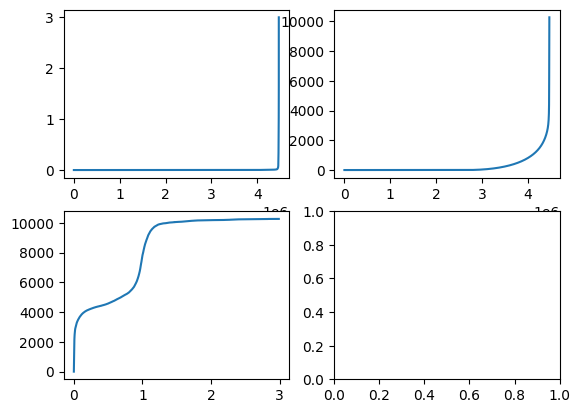

In [61]:
if not running_mode == 'optuna':
    weights_L = []
    for i, layer in enumerate(model.layers):
        this_weight = layer.trainable_weights
        print('='*30)
        print(f'Layer name: {layer.name}')
        print(f'Layer Index: {i}')
        L = len(this_weight)
        for l in range(L):
            this_A = this_weight[l].numpy()
            this_A = this_A.flatten().tolist()
            if len(this_A) >= 1:
                print(np.max(np.abs(this_A)))
                for j in this_A:
                    weights_L.append(j)
    
    rY = np.sort(np.abs(weights_L))
    WY = [rY[0]]
    for i in rY[1::]:
        WY.append(WY[-1]+i)

    fig, ax = plt.subplots(2, 2)
    ax[0][0].plot(rY)
    ax[0][1].plot(WY)
    ax[1][0].plot(rY, WY)

### Sliding Window

#### Functions

In [62]:
def cut_large_source(VG, DL):
    vpr = np.array(VG.validation_patch_range)
    X_src = DL.images[VG.img_choice][np.min(vpr[:,2]):np.max(vpr[:,3]),np.min(vpr[:,0]):np.max(vpr[:,1]),:]
    y_src = DL.labels[VG.img_choice][np.min(vpr[:,2]):np.max(vpr[:,3]),np.min(vpr[:,0]):np.max(vpr[:,1])]
    mask = DL.masks[VG.img_choice][np.min(vpr[:,2]):np.max(vpr[:,3]),np.min(vpr[:,0]):np.max(vpr[:,1])]
    cut_range = [np.min(vpr[:,2]), np.max(vpr[:,3]), np.min(vpr[:,0]), np.max(vpr[:,1])]
    return X_src, y_src, mask, cut_range

def sliding_window_prediction(VG, DL, predict_func, stride=16, threshold=0.5, plot_figure=False):
    this_X_src, this_y_src, this_mask, cut_range = cut_large_source(VG, DL)
    
    nx = int(this_X_src.shape[1]/stride - patch_size/stride + 1)
    ny = int(this_X_src.shape[0]/stride - patch_size/stride + 1)
    print([nx, ny])
    total_score = np.zeros((ny*stride + patch_size - stride, nx*stride + patch_size - stride))
    total_count = np.zeros((ny*stride + patch_size - stride, nx*stride + patch_size - stride))
    
    
    X_s = np.zeros((nx*ny,patch_size,patch_size,this_X_src.shape[-1]))
    Y_s = np.zeros((nx*ny,patch_size,patch_size))
    idx = []
    count = 0
    for xi in tqdm(range(nx)):
        for yi in range(ny):
            this_X = this_X_src[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size, :]
            this_y = this_y_src[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size]
            small_mask = this_mask[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size]
            if np.mean(small_mask) == 1:
                X_s[count] = this_X
                Y_s[count] = this_y
                idx.append([xi, yi])
                count += 1
    n_count = count
    X_s = X_s[0:n_count]
    Y_s = Y_s[0:n_count]
    if threeD_conv:
        X_s = np.expand_dims(X_s, axis=4)
    
    print(X_s.shape)
    Y_pred = predict_func(X_s)[:,:,:,0]
    
    for i, this_idx in enumerate(idx):
        xi = this_idx[0]; yi = this_idx[1]
        total_count[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size] += 1
        total_score[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size] += Y_pred[i]
    
    pred_y = (total_score/total_count).astype(np.float16)
    pred_y[np.isnan(pred_y)] = 0
    
    this_pred = pred_y * 0
    this_pred[pred_y >= threshold] = 1
    dice = Sorensen_Dice_coef_for_ndarray(this_y_src, this_pred)
    
    if plot_figure:
        fig, ax = plt.subplots()
        ax.imshow(this_pred, vmax=1, vmin=0, cmap='gray')
        ax.imshow(this_y_src, vmax=1, vmin=0, alpha=0.5, cmap='winter')
        fig.set_size_inches((6, 6))
    
    Best_Pred = {'pred':this_pred, 'range':cut_range}
    
    if plot_figure:
        return Best_Pred, fig, ax
    else:
        return Best_Pred

In [63]:
def sliding_window_prediction_multi_class(VG, DL, model, class_id, stride=16, best_threshold=None, plot_figure=False):
    this_X_src, this_y_src, this_mask, cut_range = cut_large_source(VG, DL)
    
    nx = int(this_X_src.shape[1]/stride - patch_size/stride + 1)
    ny = int(this_X_src.shape[0]/stride - patch_size/stride + 1)
    total_score = np.zeros((ny*stride + patch_size - stride, nx*stride + patch_size - stride))
    total_count = np.zeros((ny*stride + patch_size - stride, nx*stride + patch_size - stride))
    total_truth = np.zeros((ny*stride + patch_size - stride, nx*stride + patch_size - stride))
    
    
    X_s = np.zeros((nx*ny,patch_size,patch_size,this_X_src.shape[-1]))
    Y_s = np.zeros((nx*ny,patch_size,patch_size))
    idx = []
    count = 0
    for xi in range(nx):
        for yi in range(ny):
            this_X = this_X_src[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size, :]
            this_y = this_y_src[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size]
            small_mask = this_mask[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size]
            if np.mean(small_mask) == 1:
                X_s[count] = this_X
                Y_s[count] = this_y
                idx.append([xi, yi])
                count += 1
    n_count = count
    X_s = X_s[0:n_count]
    Y_s = Y_s[0:n_count]
    if threeD_conv:
        X_s = np.expand_dims(X_s, axis=4)
    if supervision:
        raw_y = model.predict(X_s, verbose=0)[-1]
    else:
        raw_y = model.predict(X_s, verbose=0)
    print(raw_y.shape)
    Y_pred = raw_y[:,:,:,class_id]
    for i, this_idx in enumerate(idx):
        xi = this_idx[0]; yi = this_idx[1]
        total_count[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size] += 1
        total_score[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size] += Y_pred[i]
        total_truth[yi*stride:yi*stride + patch_size, xi*stride:xi*stride + patch_size] += Y_s[i,:,:]
    
    pred_y = total_score/total_count
    pred_y[np.isnan(pred_y)] = 0
    true_y = total_truth/total_count
    true_y[np.isnan(true_y)] = 0
    
    return pred_y, true_y

#### Sliding Window Evaluation

[61, 61]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 26.52it/s]


(3721, 96, 96, 24, 1)
117/117 [==============================] - 4s 22ms/step
[61, 61]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 26.90it/s]


(3721, 96, 96, 24, 1)
117/117 [==============================] - 4s 28ms/step
[61, 61]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 26.10it/s]


(3721, 96, 96, 24, 1)
117/117 [==============================] - 4s 26ms/step


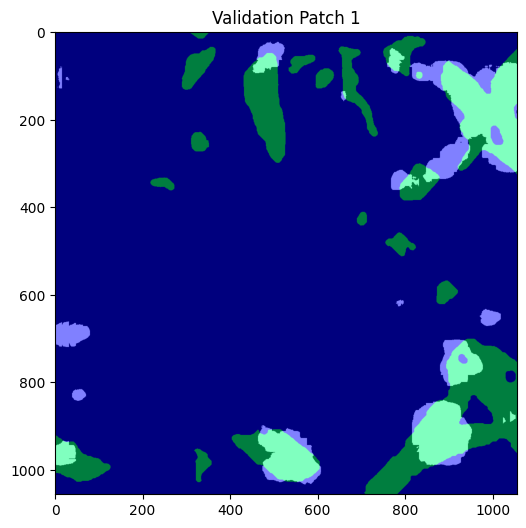

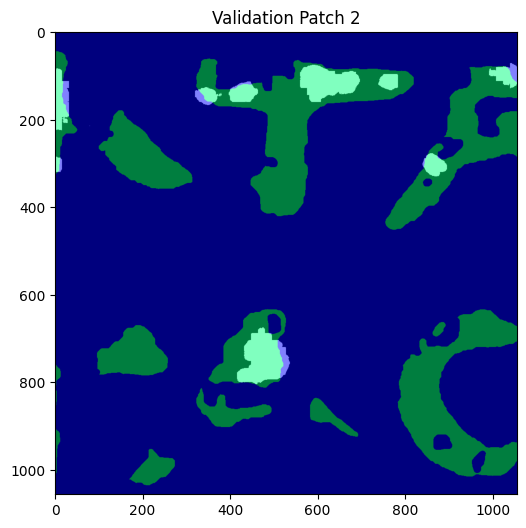

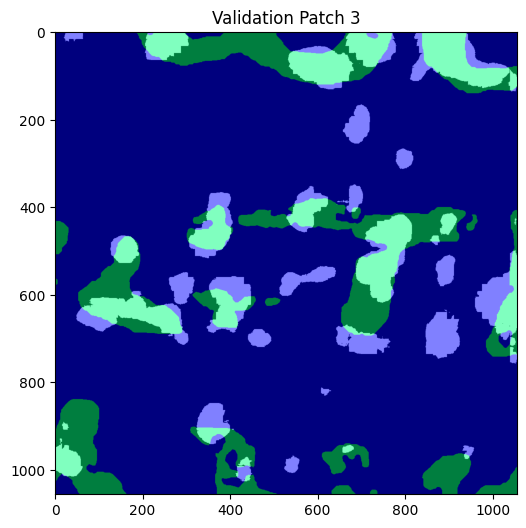

In [64]:
if not running_mode == 'optuna':
    sliding_preds = []
    patch_type = 'Validation'
    for i in range(len(VGs)):
        this_Pred, fig, ax = sliding_window_prediction(VGs[i], DL,
                                                   predict_func,
                                                   stride=16, threshold=0.5,
                                                   plot_figure=True)
        ax.set_title(f'{patch_type} Patch {i+1}')
        fig.savefig(this_model_path + f'Ink_Prediction_Sliding_{patch_type[0]}{i}.jpg')
        sliding_preds.append(this_Pred)

[61, 61]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 27.33it/s]


(3721, 96, 96, 24, 1)
117/117 [==============================] - 4s 26ms/step
[61, 61]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 26.00it/s]


(3721, 96, 96, 24, 1)
117/117 [==============================] - 4s 27ms/step
[61, 61]


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:02<00:00, 25.69it/s]


(3721, 96, 96, 24, 1)
117/117 [==============================] - 4s 28ms/step


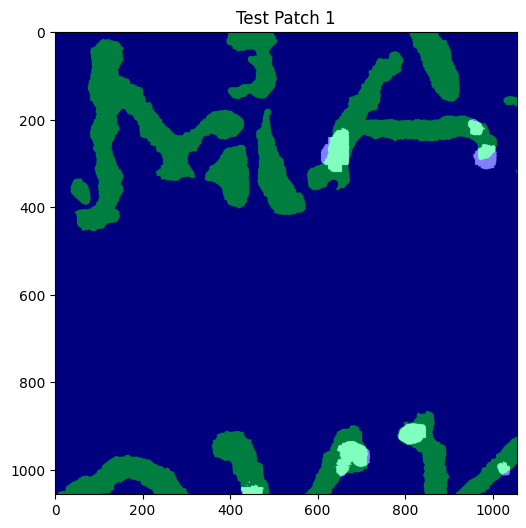

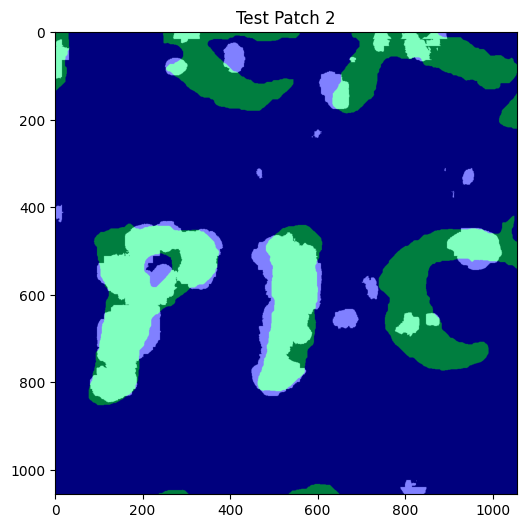

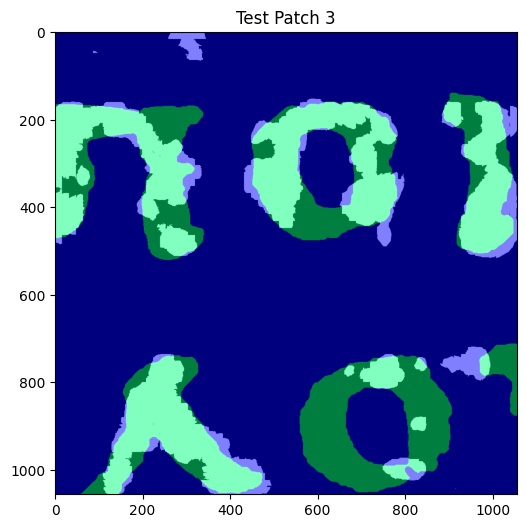

In [65]:
if not running_mode == 'optuna':
    patch_type = 'Test'
    for i in range(len(test_Gs)):
        this_Pred, fig, ax = sliding_window_prediction(test_Gs[i], DL,
                                                   predict_func,
                                                   stride=16, threshold=0.5,
                                                   plot_figure=True)
        ax.set_title(f'{patch_type} Patch {i+1}')
        fig.savefig(this_model_path + f'Ink_Prediction_Sliding_{patch_type[0]}{i}.jpg')
        sliding_preds.append(this_Pred)

In [77]:
sliding_metric_dict = {'Patch': [],
                       'Recall': [],
                       'Precision': [],
                       'Dice': []}

YT_list = []
YP_list = []
for i in range(len(y_val_for_train_list)):
    _, y_true, __, ___ = cut_large_source(VGs[i], DL)
    y_pred = sliding_preds[i]['pred']
    
    YT_list.append(y_true)
    YP_list.append(y_pred)

    recall = Recall_for_ndarray(y_true, y_pred)
    precision = Precision_for_ndarray(y_true, y_pred)
    dice = Sorensen_Dice_coef_for_ndarray(y_true, y_pred)

    sliding_metric_dict['Patch'].append(f'V{i+1}')
    sliding_metric_dict['Recall'].append(recall)
    sliding_metric_dict['Precision'].append(precision)
    sliding_metric_dict['Dice'].append(dice)


YT = np.concatenate(YT_list, axis=0)
YP = np.concatenate(YP_list, axis=0)
recall = Recall_for_ndarray(YT, YP)
precision = Precision_for_ndarray(YT, YP)
dice = Sorensen_Dice_coef_for_ndarray(YT, YP)

sliding_metric_dict['Patch'].append('ALL_V')
sliding_metric_dict['Recall'].append(recall)
sliding_metric_dict['Precision'].append(precision)
sliding_metric_dict['Dice'].append(dice)



YT_list = []
YP_list = []
for i in range(len(y_test_list)):
    _, y_true, __, ___ = cut_large_source(test_Gs[i], DL)
    y_pred = sliding_preds[i + len(y_val_for_train_list)]['pred']
    
    YT_list.append(y_true)
    YP_list.append(y_pred)

    recall = Recall_for_ndarray(y_true, y_pred)
    precision = Precision_for_ndarray(y_true, y_pred)
    dice = Sorensen_Dice_coef_for_ndarray(y_true, y_pred)

    sliding_metric_dict['Patch'].append(f'T{i+1}')
    sliding_metric_dict['Recall'].append(recall)
    sliding_metric_dict['Precision'].append(precision)
    sliding_metric_dict['Dice'].append(dice)

YT = np.concatenate(YT_list, axis=0)
YP = np.concatenate(YP_list, axis=0)
recall = Recall_for_ndarray(YT, YP)
precision = Precision_for_ndarray(YT, YP)
dice = Sorensen_Dice_coef_for_ndarray(YT, YP)

sliding_metric_dict['Patch'].append('ALL_T')
sliding_metric_dict['Recall'].append(recall)
sliding_metric_dict['Precision'].append(precision)
sliding_metric_dict['Dice'].append(dice)

In [78]:
sliding_df = pd.DataFrame(sliding_metric_dict)

In [79]:
sliding_df

,Patch,Recall,Precision,Dice
0,V1,0.416084,0.671418,0.598022
1,V2,0.131245,0.886710,0.412187
2,V3,0.447608,0.573975,0.543299
3,ALL_V,0.318466,0.641636,0.533383
4,T1,0.076224,0.856017,0.281024
5,T2,0.477998,0.779188,0.691983
6,T3,0.595443,0.828922,0.768643
7,ALL_T,0.422246,0.811193,0.684997


In [80]:
merics_df = ensemble_df.merge(sliding_df, on='Patch', suffixes=['_ensemble', '_sliding'])
merics_df = merics_df[['Patch', 'Recall_ensemble', 'Recall_sliding',
                       'Precision_ensemble', 'Precision_sliding',
                       'Dice_ensemble', 'Dice_sliding']]
merics_df

,Patch,Recall_ensemble,Recall_sliding,Precision_ensemble,Precision_sliding,Dice_ensemble,Dice_sliding
0,V1,0.374050,0.416084,0.670511,0.671418,0.578768,0.598022
1,V2,0.105786,0.131245,0.715687,0.886710,0.332401,0.412187
2,V3,0.387228,0.447608,0.572577,0.573975,0.522553,0.543299
3,ALL_V,0.276384,0.318466,0.623381,0.641636,0.498267,0.533383
4,T1,0.061725,0.076224,0.897984,0.856017,0.242068,0.281024
5,T2,0.408972,0.477998,0.710773,0.779188,0.619362,0.691983
6,T3,0.525539,0.595443,0.819538,0.828922,0.737071,0.768643
7,ALL_T,0.367295,0.422246,0.780646,0.811193,0.637221,0.684997


In [81]:
merics_df.to_csv(this_model_path + 'metric_comparison_between_ensembles.csv')

In [88]:
with open(this_model_path + 'ensemble_operation_parameters.txt', 'w') as f:
    for key in operation_parameters.keys():
        f.write(f'{key} = {operation_parameters[key]} \n')